# Banking research analysis 2

Research questions:
 - is the transmission of ECB conventional monetary policy effective on banks’ volumes and banks’ rates since 2014?
 - is there a time lag?

## Importing dependecies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from matplotlib import style
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Setting style for every plot
plt.style.use('seaborn')

# or 'ggplot' style

C:\Users\david\AppData\Local\Temp\ipykernel_6700\3282746314.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Data preparation

The data was gathered from the Statistical Data Warehouse webite affiliated with the ECB. After some considerations we decided to extract data relative to:
- MRO
- Cost of borrowings (< and > 1 year maturity)
- Loan rates outstandings
- business volumes of loans
- business volumes of deposits
- bank's lending margins over euro area countries

After some excel modifications and merging the datasets, we ended up with two cleaned datasets: one with the first 5 parts from above (110 rows x 21 columns), and one with the lending margins (110 rows x 20 columns).

Both datasets are indexed through date: we gathered monthly data from January 2014 up until March 2023.

In [4]:
df = pd.read_excel('datasets/MRO.xls')

In [5]:
df.drop(0, 0, inplace=True)

C:\Users\david\AppData\Local\Temp\ipykernel_6700\2701482825.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(0, 0, inplace=True)


In [6]:
df = df.iloc[::-1,].reset_index(drop=True)
df.rename(columns={'Value' : 'MRO'}, inplace=True)
df

Date   MRO
0   2014-01-01  0.25
1   2014-02-01  0.25
2   2014-03-01  0.25
3   2014-04-01  0.25
4   2014-05-01  0.25
..         ...   ...
105 2022-10-01  2.00
106 2022-11-01  2.00
107 2022-12-01  2.50
108 2023-01-01  3.00
109 2023-02-01  3.00

[110 rows x 2 columns]

In [7]:
df_rates = pd.read_excel('datasets/LoansRates_outstandings.xls', sheet_name='Sheet1')
df_rates = df_rates.iloc[::-1,].reset_index(drop=True)
# df_rates

In [8]:
df_cob = pd.read_excel('datasets/cob_movingaverage.xls', sheet_name='Sheet1')
df_cob = df_cob.iloc[::-1,].reset_index(drop=True)
# df_cob

In [9]:
df_loans = pd.read_excel('datasets/Volumes_loans.xls', sheet_name= 'Sheet1')
df_loans = df_loans.iloc[::-1,].reset_index(drop=True)
# df of volumes for loans

In [10]:
df_deposits = pd.read_excel('datasets/Volumes_deposits.xls', sheet_name= 'Sheet1')
df_deposits = df_deposits.iloc[::-1,].reset_index(drop=True)
# df of volumes for deposits

In [11]:
data = pd.concat([df, df_cob.iloc[:, 1:], df_rates.iloc[:, 1:], df_loans.iloc[:, 1:], df_deposits.iloc[:, 1:]], axis=1)
data.head()
# data for volumes in million of euros
# MRO, Cob, and rates are all in percentages

Date   MRO  Cob, up to 1 year  Cob, over 1 year  \
0 2014-01-01  0.25               2.95              3.22   
1 2014-02-01  0.25               2.95              3.18   
2 2014-03-01  0.25               2.97              3.16   
3 2014-04-01  0.25               2.96              3.13   
4 2014-05-01  0.25               2.90              3.06   

   Rates to NFC loans, up to 1 year  Rates to NFC loans, over 1 year  \
0                              3.69                             3.17   
1                              3.66                             3.21   
2                              3.64                             3.18   
3                              3.65                             3.18   
4                              3.60                             3.17   

   Rates for house purchases, up to 1 year  \
0                                     3.31   
1                                     3.30   
2                                     3.30   
3                                     3.37   
4                                     3.33   

   Rates for house purchases, over 1 year  \
0                                    3.29   
1                                    3.35   
2                                    3.32   
3                                    3.30   
4                                    3.28   

   Rates for consumptions and others, up to 1 year  \
0                                             7.62   
1                                             7.67   
2                                             7.64   
3                                             7.55   
4                                             7.54   

   Rates for consumptions, over 1 year  ...  \
0                                 5.01  ...   
1                                 5.09  ...   
2                                 5.01  ...   
3                                 5.03  ...   
4                                 5.01  ...   

   Lending for house purchases, up to 1 year  \
0                                   12198.65   
1                                   11580.23   
2                                   12564.71   
3                                   12458.21   
4                                   12170.53   

   Lending for house purchases, over 1 year  \
0                                  29437.53   
1                                  27872.59   
2                                  29067.69   
3                                  31706.92   
4                                  29756.39   

   Loans for households consumptions, up to 1 year  \
0                                          2688.41   
1                                          2377.54   
2                                          2650.09   
3                                          2557.98   
4                                          2423.85   

   Loans for households consumptions, over 1 year  \
0                                        12021.54   
1                                        12072.53   
2                                        13465.63   
3                                        14040.44   
4                                        13575.69   

   Deposits of NFC, Up to 1 year  Deposits of Households, up to 1 year  \
0                      111432.62                              81815.73   
1                       96006.44                              67314.52   
2                       99171.82                              66901.36   
3                      114382.59                              70771.75   
4                       99891.56                              67133.09   

   Deposits of NFC, over 1 and up to 2 years  \
0                                    4705.88   
1                                    3691.90   
2                                    3377.05   
3                                    3649.89   
4                                    3600.78   

   Deposits of Households, over 1 and up to 2 years  \
0                                          23591.92   
1   

In [12]:
data['Date'] = data['Date'].apply(pd.to_datetime)
data.set_index('Date',inplace=True)
data.head()

MRO  Cob, up to 1 year  Cob, over 1 year  \
Date                                                    
2014-01-01  0.25               2.95              3.22   
2014-02-01  0.25               2.95              3.18   
2014-03-01  0.25               2.97              3.16   
2014-04-01  0.25               2.96              3.13   
2014-05-01  0.25               2.90              3.06   

            Rates to NFC loans, up to 1 year  Rates to NFC loans, over 1 year  \
Date                                                                            
2014-01-01                              3.69                             3.17   
2014-02-01                              3.66                             3.21   
2014-03-01                              3.64                             3.18   
2014-04-01                              3.65                             3.18   
2014-05-01                              3.60                             3.17   

            Rates for house purchases, up to 1 year  \
Date                                                  
2014-01-01                                     3.31   
2014-02-01                                     3.30   
2014-03-01                                     3.30   
2014-04-01                                     3.37   
2014-05-01                                     3.33   

            Rates for house purchases, over 1 year  \
Date                                                 
2014-01-01                                    3.29   
2014-02-01                                    3.35   
2014-03-01                                    3.32   
2014-04-01                                    3.30   
2014-05-01                                    3.28   

            Rates for consumptions and others, up to 1 year  \
Date                                                          
2014-01-01                                             7.62   
2014-02-01                                             7.67   
2014-03-01                                             7.64   
2014-04-01                                             7.55   
2014-05-01                                             7.54   

            Rates for consumptions, over 1 year  Loans to NFC, up to 1 year  \
Date                                                                          
2014-01-01                                 5.01                   177949.29   
2014-02-01                                 5.09                   148452.00   
2014-03-01                                 5.01                   170872.68   
2014-04-01                                 5.03                   179919.58   
2014-05-01                                 5.01                   154976.81   

            ...  Lending for house purchases, up to 1 year  \
Date        ...                                              
2014-01-01  ...                                   12198.65   
2014-02-01  ...                                   11580.23   
2014-03-01  ...                                   12564.71   
2014-04-01  ...                                   12458.21   
2014-05-01  ...                                   12170.53   

            Lending for house purchases, over 1 year  \
Date                                                   
2014-01-01                                  29437.53   
2014-02-01                                  27872.59   
2014-03-01                                  29067.69   
2014-04-01                                  31706.92   
2014-05-01                                  29756.39   

            Loans for households consumptions, up to 1 year  \
Date                                                          
2014-01-01                                          2688.41   
2014-02-01                                          2377.54   
2014-03-01                                          2650.09   
2014-04-01                                          2557.98   
2014-05-01                                          2423.85   

            Lo

In [13]:
margins = pd.read_excel('datasets/banks_lending_margins.xls', sheet_name='Sheet1')
margins = margins.iloc[::-1,].reset_index(drop=True)

margins['Date'] = margins['Date'].apply(pd.to_datetime)
margins.set_index('Date',inplace=True)
margins.head()

Austria  Belgium  Cyprus  Germany  Estonia   Spain  Finland  \
Date                                                                      
2014-01-01   1.3609   1.4896  3.3124   1.8328   2.2141  2.3167   1.2122   
2014-02-01   1.3404   1.5041  2.7681   1.8280   2.5632  2.4728   1.3086   
2014-03-01   1.3017   1.5139  2.8993   1.9497   2.6848  2.5406   1.4667   
2014-04-01   1.2752   1.5406  2.8666   1.8342   2.7590  2.6922   1.2043   
2014-05-01   1.3140   1.5722  2.8086   1.8328   2.3384  2.6095   1.1124   

            France  Greece  Ireland   Italy  Lithuania  Luxembourg  Latvia  \
Date                                                                         
2014-01-01  1.4653  2.6470   2.5885  1.6463     2.4456      1.4014  3.4374   
2014-02-01  1.4944  2.3820   2.8328  1.6513     2.3696      1.4727  3.7921   
2014-03-01  1.4645  2.4275   2.9685  1.6675     2.1816      1.4459  3.2930   
2014-04-01  1.4104  3.7878   2.8713  1.7406     2.4896      1.4042  3.9488   
2014-05-01  1.4790  2.8461   2.8505  1.5861     2.3504      1.3984  2.5767   

             Malta  Netherlands  Portugal  Slovenia  Slovakia  EU_average  
Date                                                                       
2014-01-01  1.6537       2.3175    3.5345    2.6039    2.2076    2.194074  
2014-02-01  2.2154       2.3583    3.3568    3.1184    1.9953    2.253911  
2014-03-01  2.5365       2.4864    3.8627    3.1681    2.0317    2.310032  
2014-04-01  1.8695       2.3292    3.7964    3.4996    2.1213    2.391621  
2014-05-01  2.3807       2.2962    3.8959    3.3832    1.9983    2.243653

In [14]:
margins.shape

(110, 20)

In [15]:
ind_dict = {}
for i, col in enumerate(data.columns):
    ind_dict[i] = col
ind_dict

{0: 'MRO',
 1: 'Cob, up to 1 year',
 2: 'Cob, over 1 year',
 3: 'Rates to NFC loans, up to 1 year',
 4: 'Rates to NFC loans, over 1 year',
 5: 'Rates for house purchases, up to 1 year',
 6: 'Rates for house purchases, over 1 year',
 7: 'Rates for consumptions and others, up to 1 year',
 8: 'Rates for consumptions, over 1 year',
 9: 'Loans to NFC, up to 1 year',
 10: 'Loans to NFC, over 1 year',
 11: 'Lending for house purchases, up to 1 year',
 12: 'Lending for house purchases, over 1 year',
 13: 'Loans for households consumptions, up to 1 year',
 14: 'Loans for households consumptions, over 1 year',
 15: 'Deposits of NFC, Up to 1 year',
 16: 'Deposits of Households, up to 1 year',
 17: 'Deposits of NFC, over 1 and up to 2 years',
 18: 'Deposits of Households, over 1 and up to 2 years',
 19: 'Deposits of NFC, over 2 years',
 20: 'Deposits of Households, over 2 years'}

## Rates

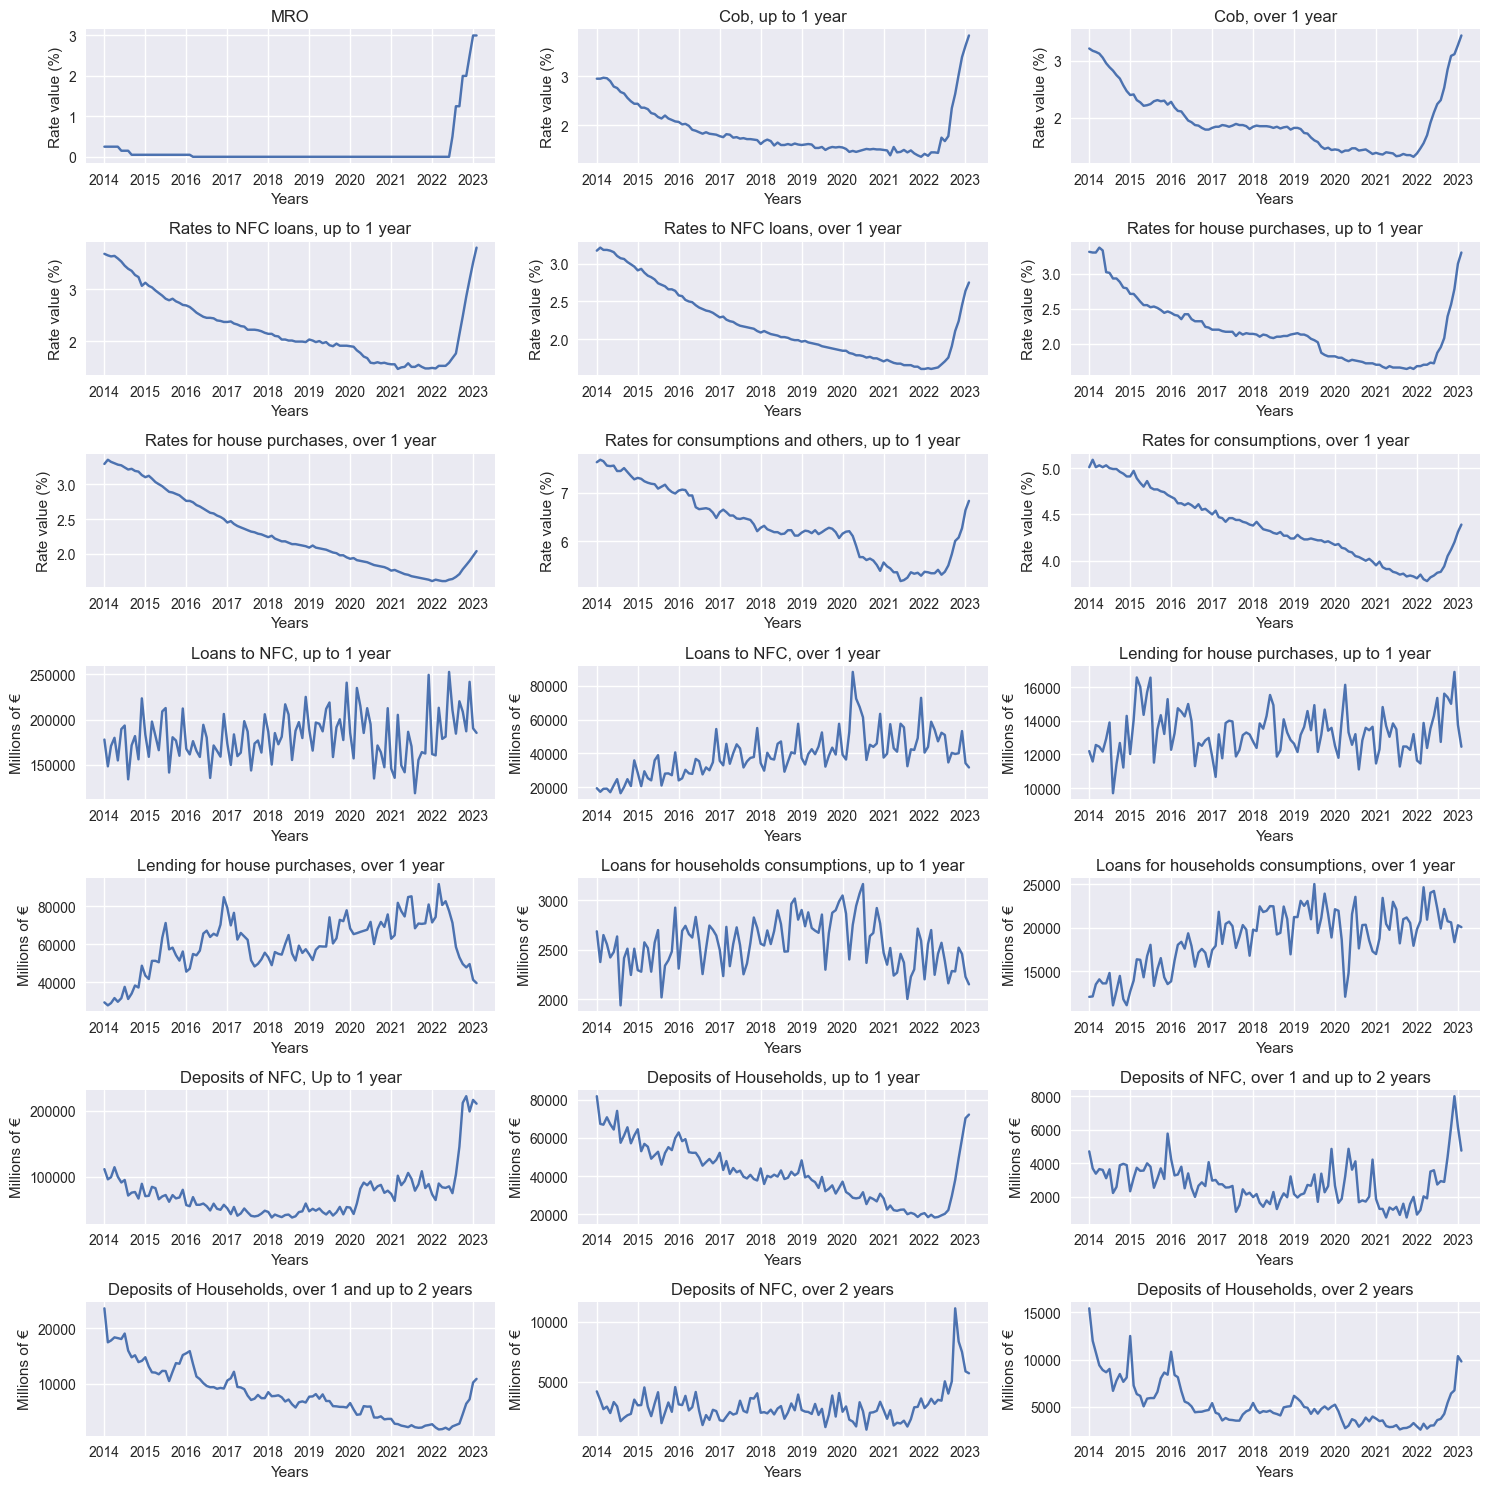

In [16]:
# general overview of all features

fig, ax = plt.subplots(7, 3, figsize=(15, 15))
ax = ax.flatten()                          # realy useful: n-dim -> uni-dim array (could also use ax.ravel())
for i, col in enumerate(data.columns):
    ax[i].plot(data.index, data[col])
    ax[i].set_title(col)
    ax[i].set_xlabel('Years')
    if i < 9:
        ax[i].set_ylabel('Rate value (%)')
    else:
        ax[i].set_ylabel('Millions of €') 
plt.tight_layout()                          # to avoid overlapping of subplots
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_6700\647468761.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
C:\Users\david\AppData\Local\Temp\ipykernel_6700\647468761.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


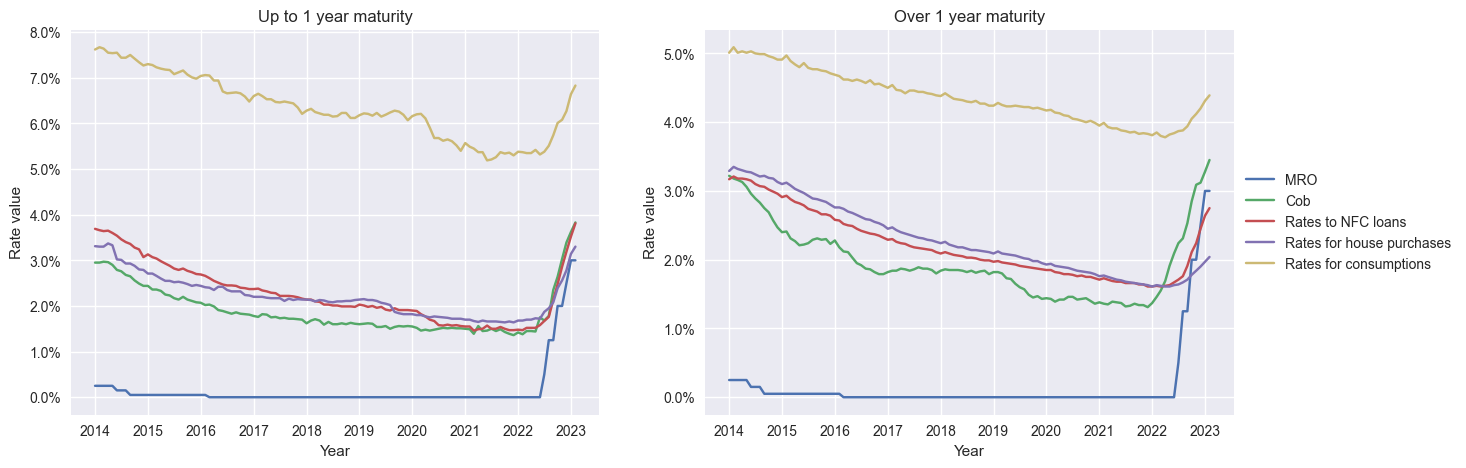

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(data.loc[:, ['MRO']+ list(data.columns[1:9:2])], 
         label = ['MRO','Cob', 'Rates to NFC loans','Rates for house purchases','Rates for consumptions and others'])
ax1.set_ylabel('Rate value')
ax1.set_xlabel('Year')
ax1.set_title('Up to 1 year maturity')
vals = ax1.get_yticks()/100
ax1.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

ax2.plot(data.loc[:, data.columns[0:9:2]],
         label = ['MRO', 'Cob', 'Rates to NFC loans','Rates for house purchases','Rates for consumptions'])
ax2.set_ylabel('Rate value')
ax2.set_xlabel('Year')
ax2.set_title('Over 1 year maturity')
vals = ax2.get_yticks()/100
ax2.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# general title on canva: 'MRO and Rates over time'

An MRO rate of 0% means that banks no longer have to pay fees if they deposit their excess money into the central bank!! The pros to society in an era of low rates (0% in this case) are that there is a strong incentive to borrow and use those funds for future projects. A potential drawback is that firms might borrow more than they actually need and invest in projects which are riskier than if interest rates were higher.


## Periods of interest - Rates

C:\Users\david\AppData\Local\Temp\ipykernel_6700\1149793595.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


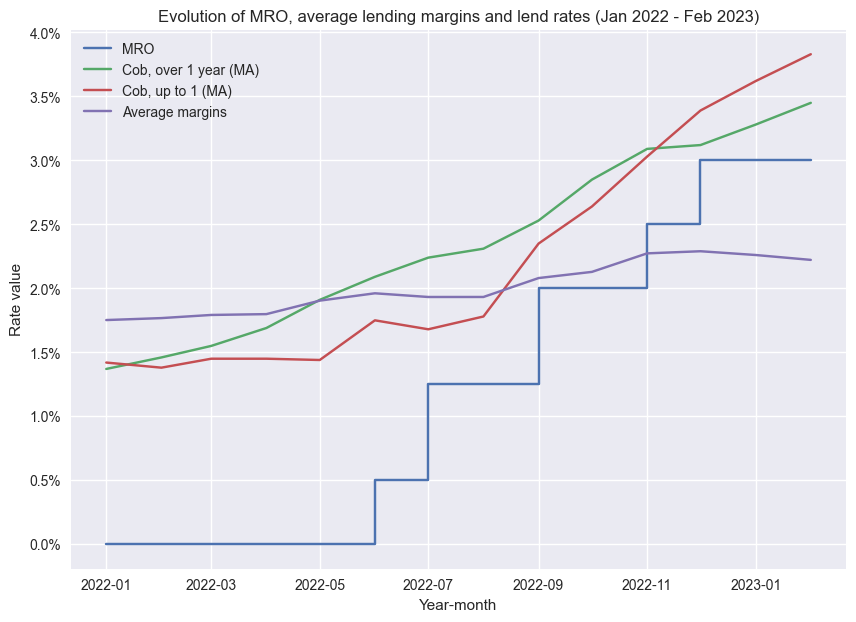

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.step(data.loc['2022-01-01':'2023-02-01', :].index, data.loc['2022-01-01':'2023-02-01', 'MRO'], label='MRO')
# ax.plot(data.loc['2022-01-01':'2023-02-01', :].index, data.loc['2022-01-01':'2023-02-01', ['Cob, over 1 year', 'Cob, up to 1 year']], label = ['Cob, over 1 year (MA)', 'Cob, up to 1 (MA)'])
# ax.plot(data.loc['2022-01-01':'2023-02-01', :].index, margins.loc['2022-01-01':'2023-02-01', 'EU_average'], label = 'Average margins')
# works also without setting the index since the date is already set as index
ax.plot(data.loc['2022-01-01':'2023-02-01', ['Cob, over 1 year', 'Cob, up to 1 year']], label = ['Cob, over 1 year (MA)', 'Cob, up to 1 (MA)'])
ax.plot(margins.loc['2022-01-01':'2023-02-01', 'EU_average'], label = 'Average margins')
ax.set_ylabel('Rate value')
ax.set_xlabel('Year-month')
ax.set_title('Evolution of MRO, average lending margins and lend rates (Jan 2022 - Feb 2023)')
plt.legend()
vals = ax.get_yticks()/100
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.show()

look for the causes of the mro changes in this period

C:\Users\david\AppData\Local\Temp\ipykernel_6700\4082555283.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


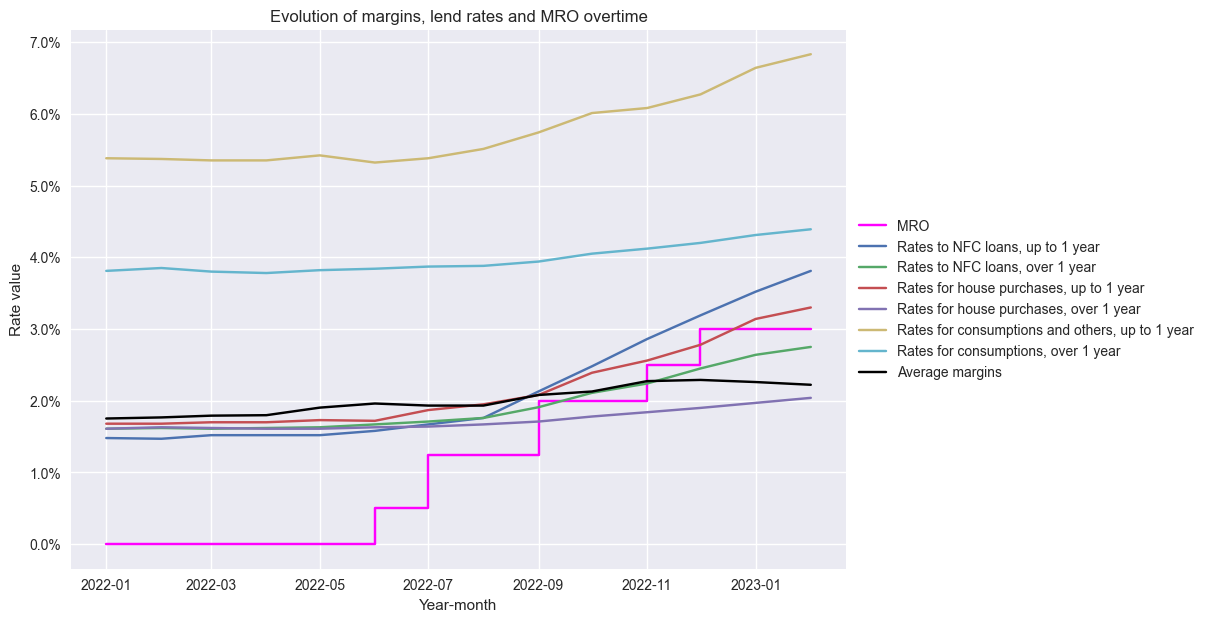

In [93]:
fig, ax = plt.subplots(1, 1,figsize = (10, 7))
ax.step(data.loc['2022-01-01':'2023-02-01', :].index, data.loc['2022-01-01':'2023-02-01', 'MRO'], label='MRO', color='magenta')
ax.plot(data.loc['2022-01-01':'2023-02-01', data.columns[3:9]], label = data.columns[3:9])
ax.plot(margins.loc['2022-01-01':'2023-02-01', 'EU_average'], label = 'Average margins', color='black')
ax.set_ylabel('Rate value')
ax.set_xlabel('Year-month')
ax.set_title('Evolution of margins, lend rates and MRO overtime')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
vals = ax.get_yticks()/100
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.show()

## Volumes - Loans and Deposits

In [20]:
# loans
data.columns[9:15]

Index(['Loans to NFC, up to 1 year', 'Loans to NFC, over 1 year',
       'Lending for house purchases, up to 1 year',
       'Lending for house purchases, over 1 year',
       'Loans for households consumptions, up to 1 year',
       'Loans for households consumptions, over 1 year'],
      dtype='object')

In [21]:
# deposits
data.columns[15:]

Index(['Deposits of NFC, Up to 1 year', 'Deposits of Households, up to 1 year',
       'Deposits of NFC, over 1 and up to 2 years',
       'Deposits of Households, over 1 and up to 2 years',
       'Deposits of NFC, over 2 years',
       'Deposits of Households, over 2 years'],
      dtype='object')

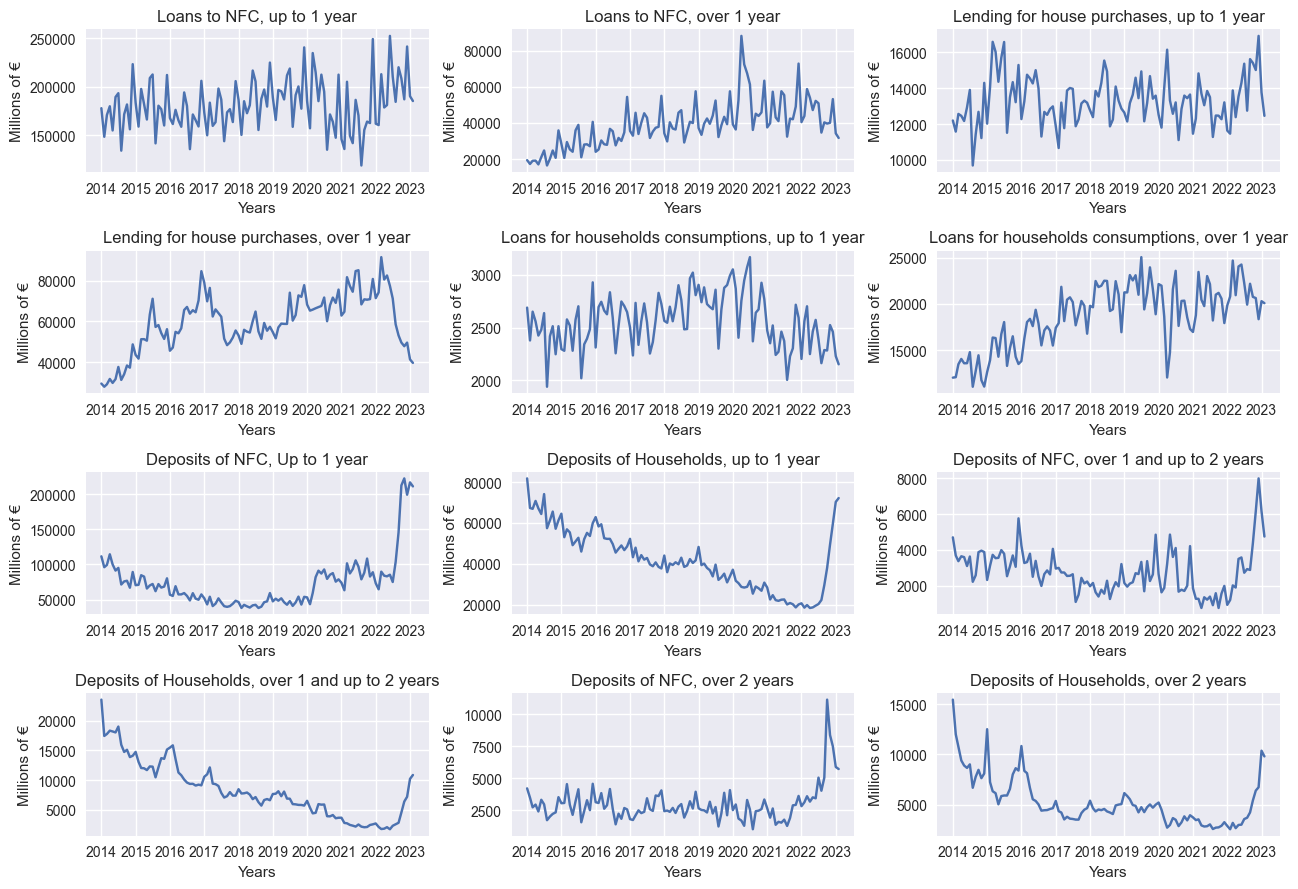

In [22]:
fig, ax = plt.subplots(4, 3, figsize=(13, 9))
ax = ax.flatten()                          # realy useful: n-dim -> uni-dim array (could also use ax.ravel())
for i, col in enumerate(data.columns[9:]):
    ax[i].plot(data.index, data[col])
    ax[i].set_title(col)
    ax[i].set_xlabel('Years')
    ax[i].set_ylabel('Millions of €') 
plt.tight_layout()                          # to avoid overlapping of subplots
plt.show()

For sure the deposits are more irregular than the loans.

Due to the large difference of scale, we have 2 options:
- plot multiple lines in single plots and showing the decompositions for the ts that are hard to analyze due to the scale;
- plot loans and deposits with different plots (as above) and commenting them.

I personally like more option 2.

### Option 1 - example

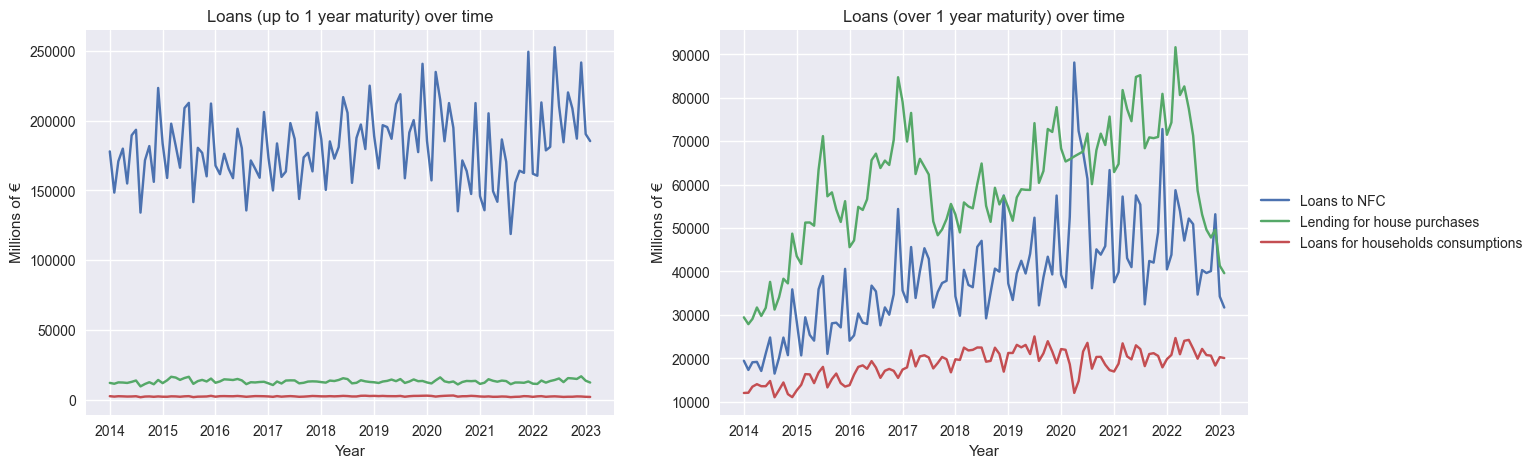

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(data.loc[:, data.columns[9:15:2]], 
        label = ['Loans to NFC','Lending for house purchases','Loans for households consumptions'])
ax1.set_ylabel('Millions of €')
ax1.set_xlabel('Year')
ax1.set_title('Loans (up to 1 year maturity) over time')

ax2.plot(data.loc[:, data.columns[10:16:2]], 
        label = ['Loans to NFC', 'Lending for house purchases','Loans for households consumptions'])
ax2.set_ylabel('Millions of €')
ax2.set_xlabel('Year')
ax2.set_title('Loans (over 1 year maturity) over time')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

<AxesSubplot: xlabel='Date'>

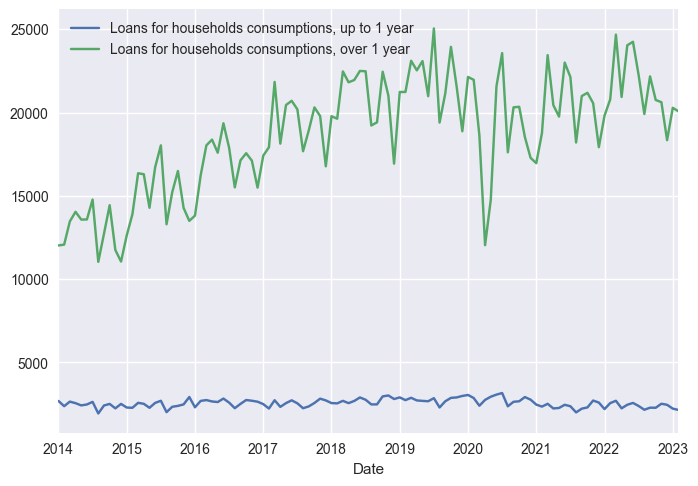

In [24]:
data.loc[:, data.columns[13:15]].plot()

here for example the green ts is more clear but the other is completely non sense, because in fact in correct scale it looks like the following, which is completely different.

<AxesSubplot: xlabel='Date'>

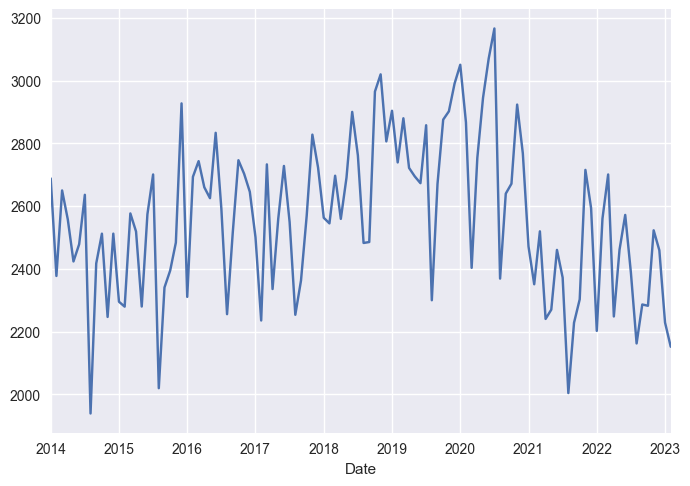

In [25]:
data.loc[:, data.columns[13]].plot()

### Option 2

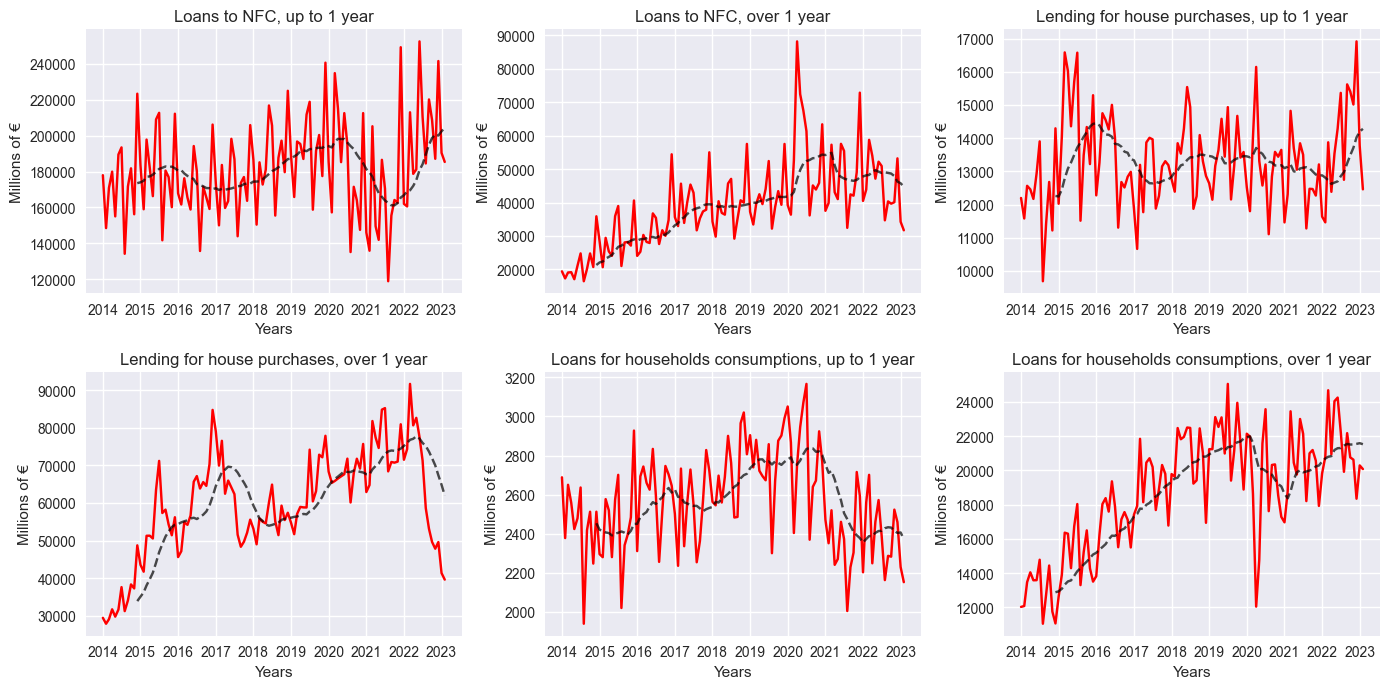

In [86]:
fig, ax = plt.subplots(2, 3, figsize=(14, 7))
ax = ax.flatten()                          
for i, col in enumerate(data.columns[9:15]):
    ax[i].plot(data.index, data[col], color="red", )
    ax[i].plot(data.rolling(window=12).mean()[col], color ="black", linestyle='dashed', alpha= 0.7)     # adding MA with a rolling window of 1 year
    ax[i].set_title(col)
    ax[i].set_xlabel('Years')
    ax[i].set_ylabel('Millions of €')
plt.tight_layout()                          
plt.show()

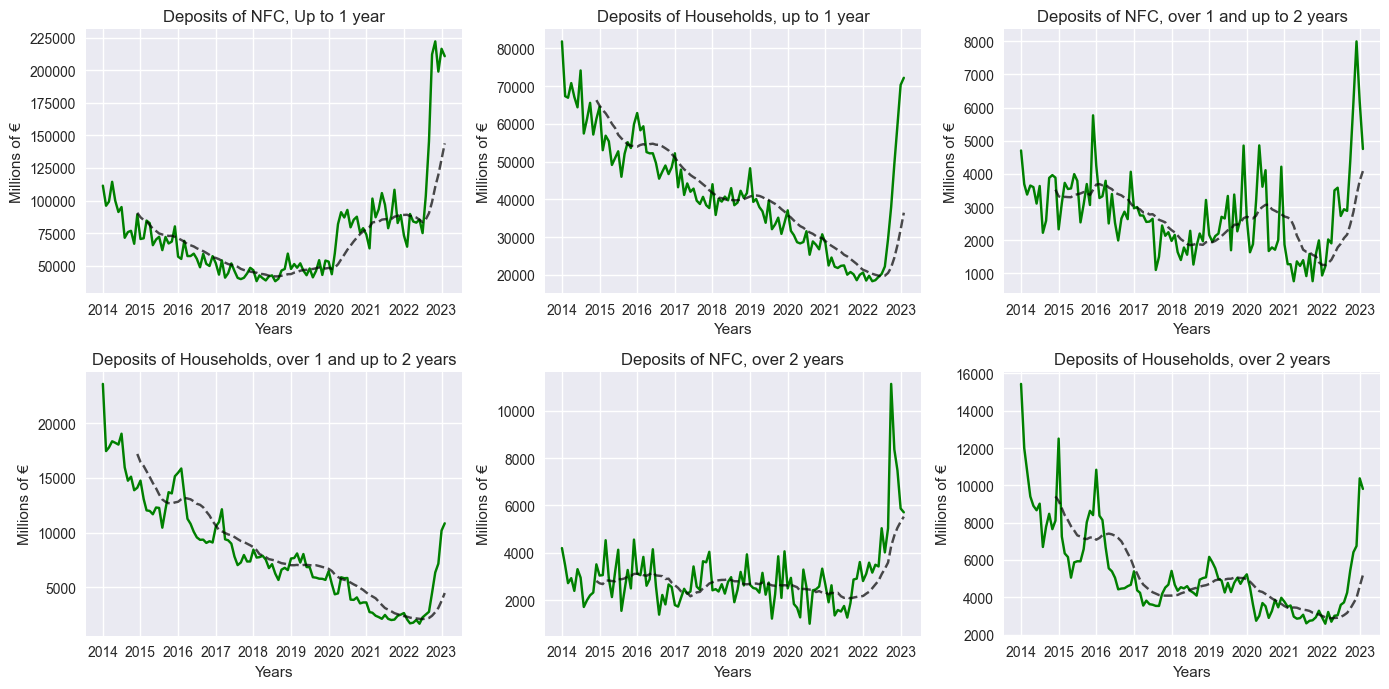

In [85]:
fig, ax = plt.subplots(2, 3, figsize=(14, 7))
ax = ax.flatten()                          
for i, col in enumerate(data.columns[15:]):
    ax[i].plot(data.index, data[col], color="green")
    ax[i].plot(data.rolling(window=12).mean()[col], color ="black", linestyle='dashed', alpha= 0.7)     # adding MA with a rolling window of 1 year
    ax[i].set_title(col)
    ax[i].set_xlabel('Years')
    ax[i].set_ylabel('Millions of €')
plt.tight_layout()                         
plt.show()

Many things could be sain from these 2 plots, added moving averages to skip the decomposition part (since it is the only thing we are interested in).

## Decompositions???

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
# seasonal_decompose(data['col']).plot()
# add model if needed

## Correlations

The MRO is always present since it is the most important thing we want to analyze.

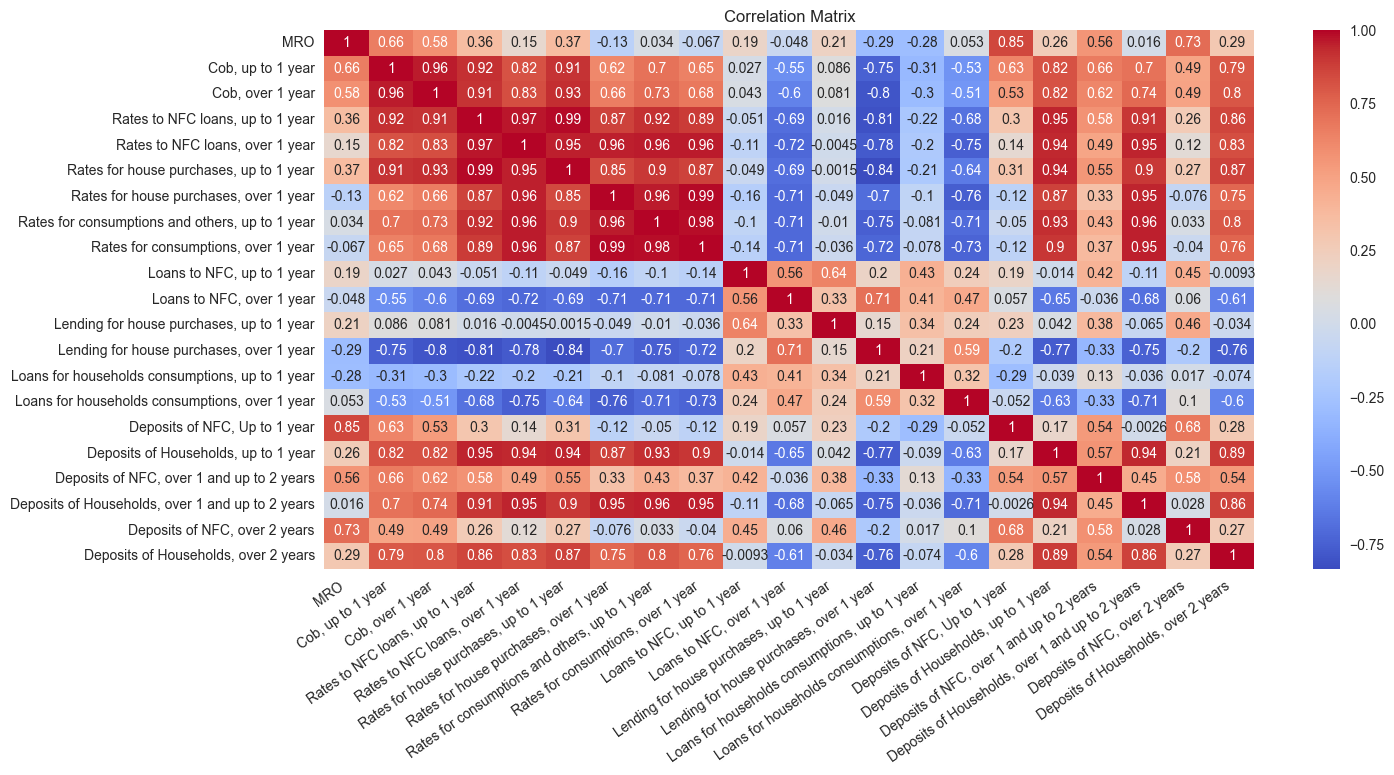

In [29]:
plt.figure(figsize= (15, 7))
corr_matrix = data.corr()
heatmap = sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=35, ha='right')
plt.title('Correlation Matrix')
plt.show()


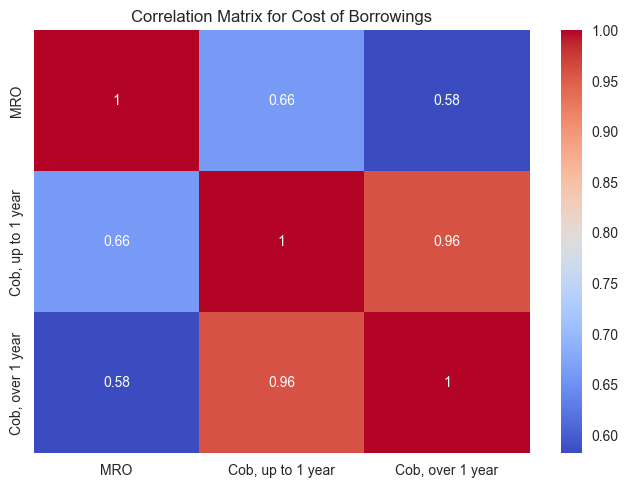

In [30]:
corr_matrix = data.iloc[:,:3].corr()
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Cost of Borrowings')
plt.show()

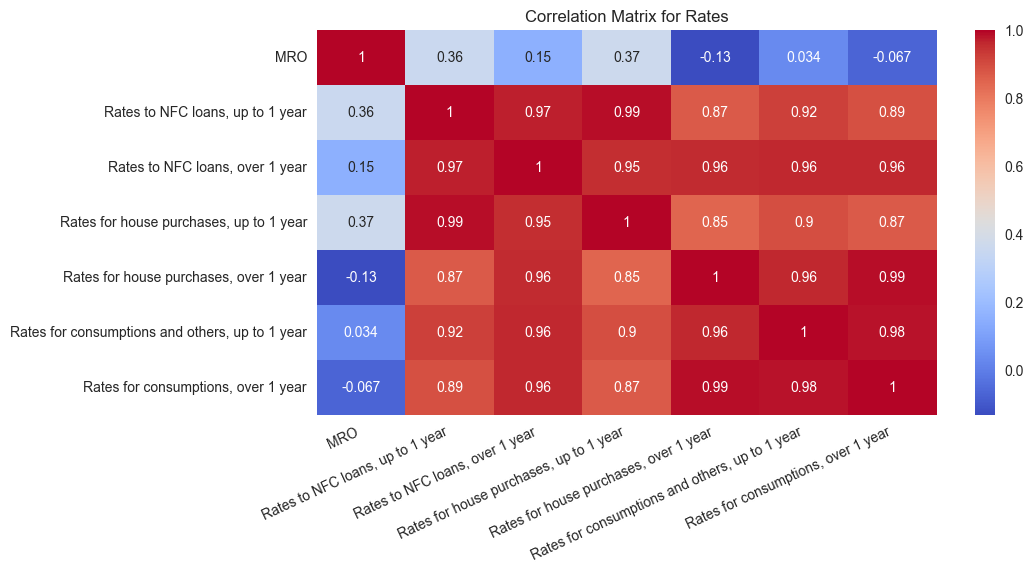

In [31]:
plt.figure(figsize= (10, 5))
corr_matrix = data.iloc[:, [0,3,4,5,6,7,8]].corr()
heatmap = sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=25, ha='right')
plt.title('Correlation Matrix for Rates')
plt.show()

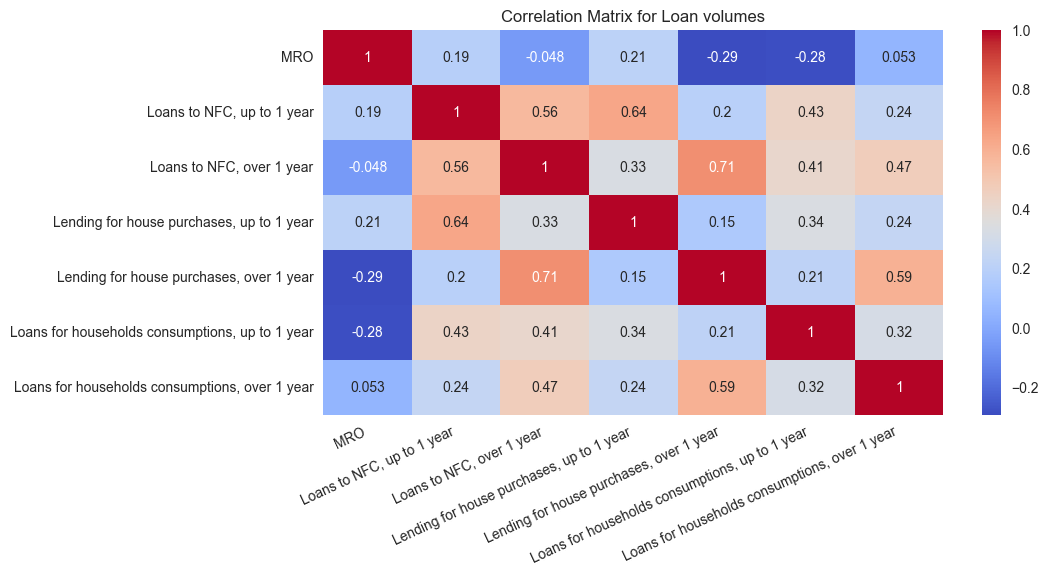

In [32]:
plt.figure(figsize= (10, 5))
corr_matrix = data.iloc[:, [0,9,10,11,12,13,14]].corr()
heatmap = sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=25, ha='right')
plt.title('Correlation Matrix for Loan volumes')
plt.show()

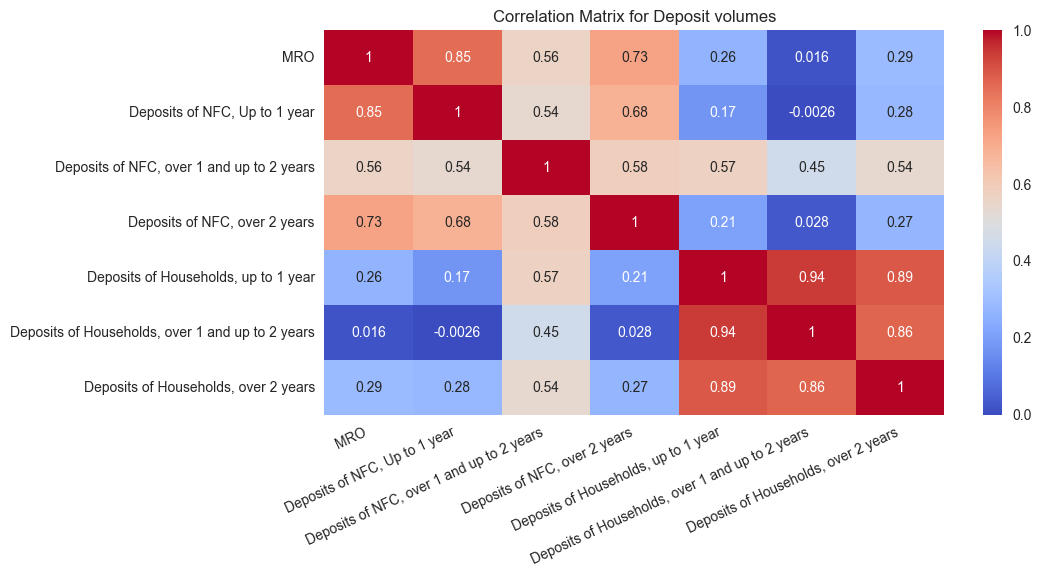

In [33]:
plt.figure(figsize= (10, 5))
corr_matrix = data.iloc[:, [0,15,17,19,16,18,20]].corr()  # numbers are to reorder the columns
heatmap = sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=25, ha='right')
plt.title('Correlation Matrix for Deposit volumes')
plt.show()

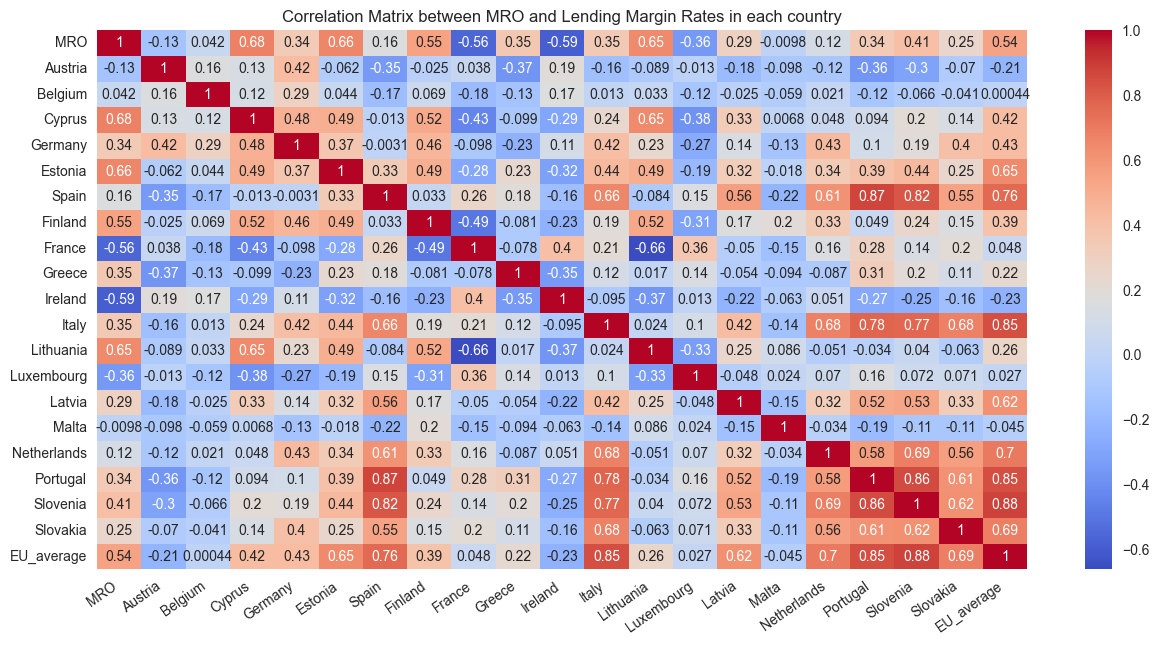

In [80]:
# only for curiosity

df_copy = pd.concat([data['MRO'], margins], axis=1)

plt.figure(figsize= (15, 7))
corr_matrix = df_copy.corr()
heatmap = sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=35, ha='right')
plt.title('Correlation Matrix between MRO and Lending Margin Rates in each country')
plt.show()

# no interesting things apart from the .54 corr between MRO and EU_average

## Time-lag analysis

Cross-correlation analysis with max 1 year lag (-12 or +12 months).

In [35]:
lags = range(-12, 13)

In [36]:
# calculating correlations between MRO and all the other columns in turn
corr_functions = {}
for col in data.columns:
    if col != 'MRO':
        corr_functions[col] = [data['MRO'].corr(data[col].shift(lag)) for lag in lags]          # shifting for n months
# corr_functions
# these are NOT percentages!!
corr_functions.items()

dict_items([('Cob, up to 1 year', [0.38051023297675307, 0.40097422376390734, 0.4202541203366467, 0.4401937217064052, 0.4647603427870805, 0.6585658700723968, 0.70200357994768, 0.7653416443157862, 0.7634151421467669, 0.7621251819990122, 0.740674028399481, 0.7046112549162954, 0.6613606860898577, 0.5627422494438247, 0.4328587843659269, 0.2816229550265018, 0.13555907377848558, -0.0009934877937953822, -0.10472376910582311, -0.1473360262854763, -0.1880261950297622, -0.2292095251351553, -0.23643892836881553, -0.2437360306316228, -0.2506031432071372]), ('Cob, over 1 year', [0.3574434164753156, 0.37606748993349687, 0.4016207605213336, 0.43462267121724074, 0.46741507061220133, 0.611516920730045, 0.6042357791627796, 0.6405592783433414, 0.6337440170303282, 0.6425237896768006, 0.627634346883989, 0.6048324573130444, 0.5815441789857253, 0.5203494268771057, 0.45010278252670555, 0.3684530704015636, 0.26315651929129835, 0.15905266410097457, 0.07372307974977467, -0.0037630131422977655, -0.0853215118542122

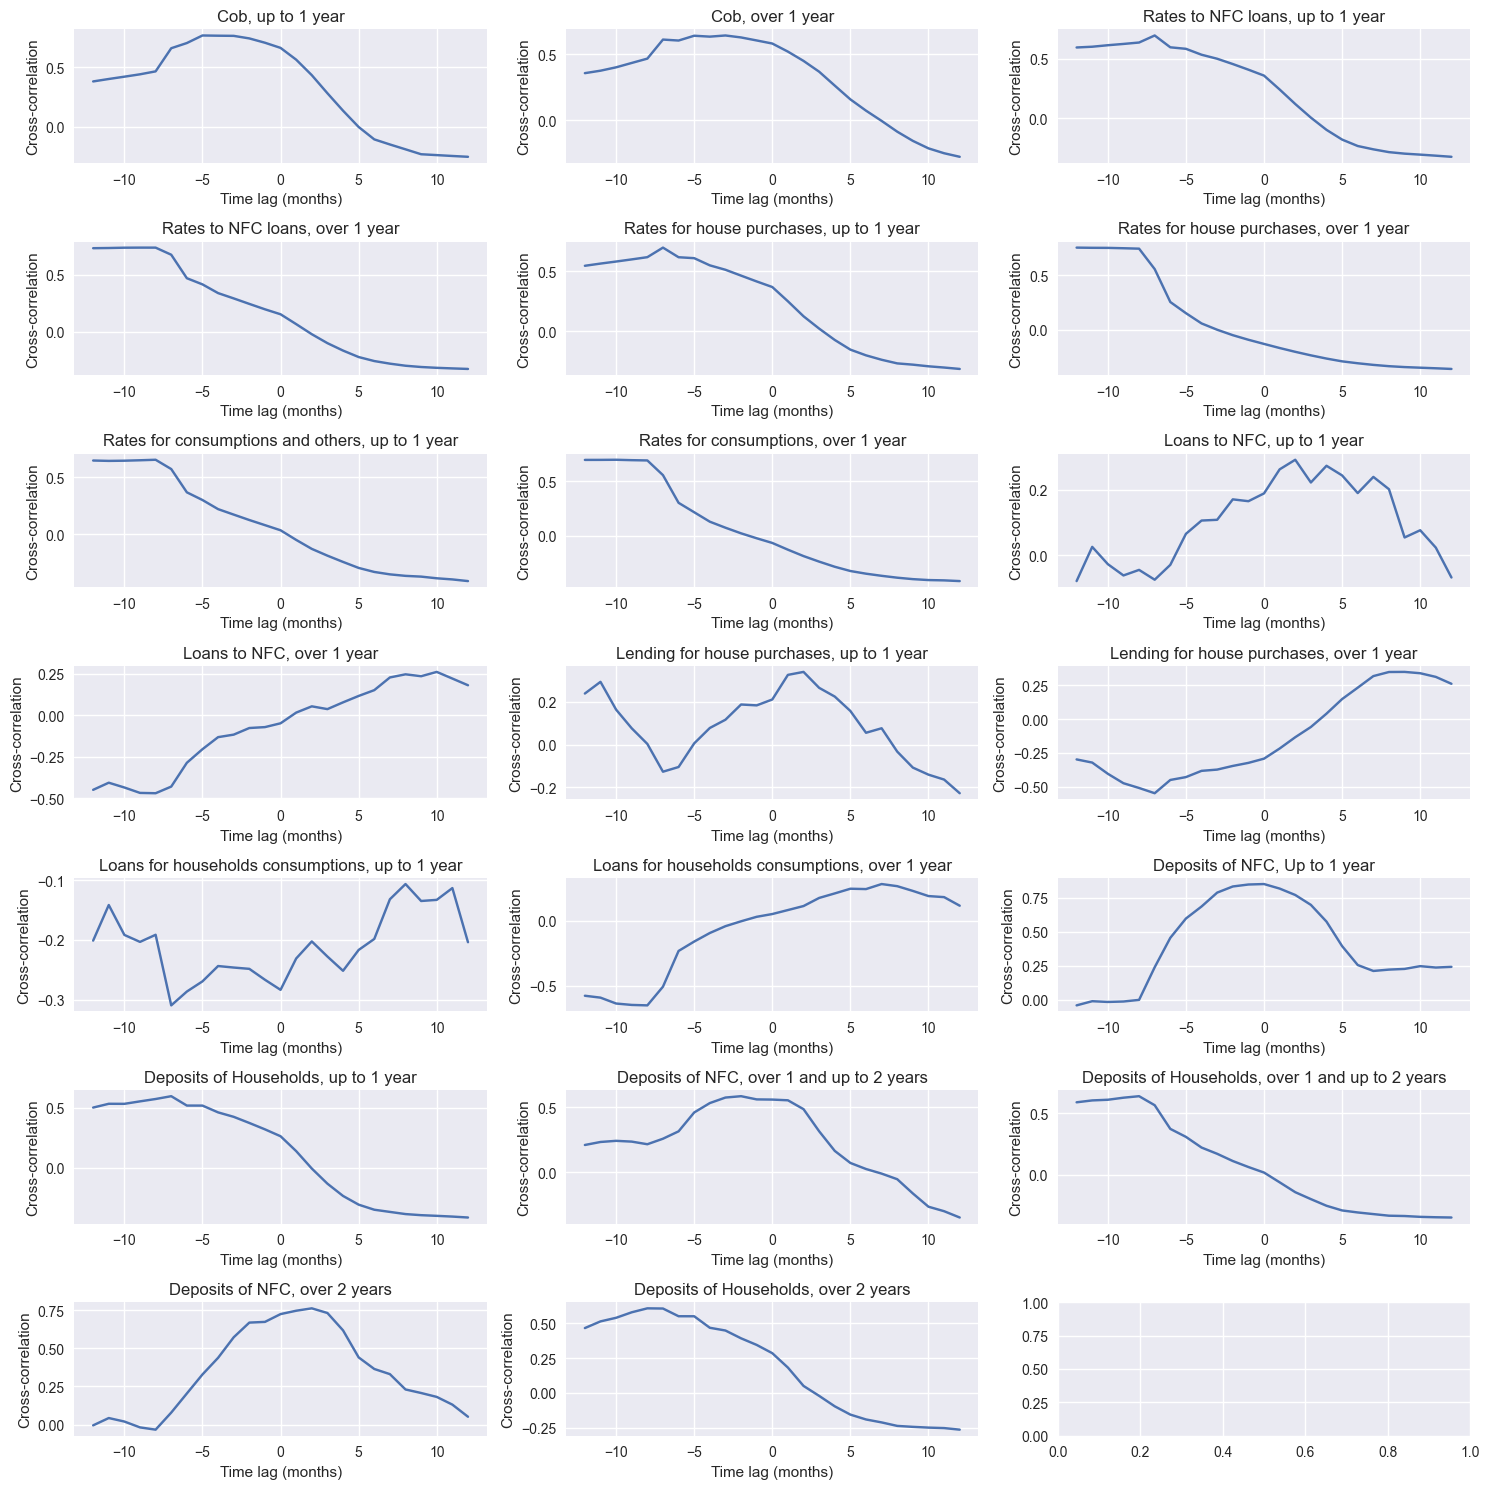

In [37]:
fig, axs = plt.subplots(7, 3, figsize=(15, 15))
axs = axs.flatten()
for i, (col, corr) in enumerate(corr_functions.items()):        # multiple indexing to put different indexes in the for loop
    axs[i].plot(lags, corr)
    axs[i].set_title(col)
    axs[i].set_xlabel('Time lag (months)')
    axs[i].set_ylabel('Cross-correlation')
plt.tight_layout()
plt.show()
# non so come mettere il titolo generale del plot ma si puo mettere direttamente da canva

The time lag analysis helps us to understand the timing of the transmission of monetary policy. The time lag analysis can thus help policymakers to evaluate the effectiveness and efficiency of their monetary policy tools and correct their policy if needed. 

The resulting plot shows the cross-correlation functions for each rate/volume in the dataset, with the time lag on the x-axis and the cross-correlation value on the y-axis. Positive time lags indicate that the MRO rate variations precede the changes in the other rate/volume, while negative time lags indicate that the changes in the other rate/volume precede the changes in the MRO rate.

If the correlation between MRO rate and a particular rate/volume shows a significant peak (drop) at a positive (negative) time lag, it indicates that the changes in MRO rate have a significant impact on the changes in the other rate/volume after (before) the lag. 

Obviously the magnitude and the direction of the time lag could provide some insights into the mechanisms of transmission of monetary policy, but we'll need more info to make some considerations. But for example, a significant positive time lag for loan rates may suggest that banks take some time to adjust their lending rates after the changes in MRO rate (maybe due to competitions? possible risks or costs?). Similarly, a significant negative time lag for loan volumes may indicate that changes in loan demand/supply may affect the MRO rate. 

## Regressions

The regressions were computed not with a predictive purpose (not to predict the future values of the rates or the volumes nor to predict the MRO) but with the aim of studying and understanding the relationship between the rates/volumes and the MRO. These regressions will give us insights on the influence the MRO has on the rates/volumes: the significance will give us info if there is a relationship while the coefficient will give us info on the magnitude and the proportionality (direct/inverse) (sign).

The regression are computed with MRO as independent variable and in turn each rate/volume as dependent variable.

General comments are in the bottom of the script.

In [38]:
# setting independent variable
X = data['MRO']

In [39]:
print("With a p-value lower than 0.05, the MRO coeff is stat significant for:")
for col in data.columns:
    if col != 'MRO':
        y = data[col]
        model = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC3') # robust covariance matrix
        if model.pvalues['MRO'] < 0.05:
            print(f'{col} - Beta = {round(model.params[1],4)}')

With a p-value lower than 0.05, the MRO coeff is stat significant for:
Cob, up to 1 year - Beta = 0.6278
Cob, over 1 year - Beta = 0.5696
Rates to NFC loans, up to 1 year - Beta = 0.4215
Rates to NFC loans, over 1 year - Beta = 0.1328
Rates for house purchases, up to 1 year - Beta = 0.3037
Rates for house purchases, over 1 year - Beta = -0.1246
Lending for house purchases, over 1 year - Beta = -7448.482
Loans for households consumptions, up to 1 year - Beta = -128.3267
Deposits of NFC, Up to 1 year - Beta = 57292.6467
Deposits of Households, up to 1 year - Beta = 7185.6966
Deposits of NFC, over 1 and up to 2 years - Beta = 1250.505
Deposits of NFC, over 2 years - Beta = 1824.7102
Deposits of Households, over 2 years - Beta = 1244.6401


With a p-value lower than 0.05, the MRO beta coefficient is stat significant for:
- Cob, up to 1 year - Beta = 0.6278
- Cob, over 1 year - Beta = 0.5696
- Rates to NFC loans, up to 1 year - Beta = 0.4215
- Rates to NFC loans, over 1 year - Beta = 0.1328
- Rates for house purchases, up to 1 year - Beta = 0.3037
- Rates for house purchases, over 1 year - Beta = -0.1246
- Lending for house purchases, over 1 year - Beta = -7448.482
- Loans for households consumptions, up to 1 year - Beta = -128.3267
- Deposits of NFC, Up to 1 year - Beta = 57292.6467
- Deposits of Households, up to 1 year - Beta = 7185.6966
- Deposits of NFC, over 1 and up to 2 years - Beta = 1250.505
- Deposits of NFC, over 2 years - Beta = 1824.7102
- Deposits of Households, over 2 years - Beta = 1244.6401

In [40]:
print("With a p-value higher than 0.05, the MRO coeff is NOT stat significant for:")
for col in data.columns:
    if col != 'MRO':
        y = data[col]
        model = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC3')
        if model.pvalues['MRO'] > 0.05:
            print(f'{col} - p(oss) = {round(model.pvalues[1],4)}')

With a p-value higher than 0.05, the MRO coeff is NOT stat significant for:
Rates for consumptions and others, up to 1 year - p(oss) = 0.5751
Rates for consumptions, over 1 year - p(oss) = 0.2242
Loans to NFC, up to 1 year - p(oss) = 0.0667
Loans to NFC, over 1 year - p(oss) = 0.497
Lending for house purchases, up to 1 year - p(oss) = 0.1688
Loans for households consumptions, over 1 year - p(oss) = 0.2095
Deposits of Households, over 1 and up to 2 years - p(oss) = 0.7986


With a p-value higher than 0.05, the MRO beta coefficient is NOT stat significant for:
- Rates for consumptions and others, up to 1 year - p(oss) = 0.5751
- Rates for consumptions, over 1 year - p(oss) = 0.2242
- Loans to NFC, up to 1 year - p(oss) = 0.0667
- Loans to NFC, over 1 year - p(oss) = 0.497
- Lending for house purchases, up to 1 year - p(oss) = 0.1688
- Loans for households consumptions, over 1 year - p(oss) = 0.2095
- Deposits of Households, over 1 and up to 2 years - p(oss) = 0.7986

In [41]:
# significant regression outputs

signif = ['Cob, up to 1 year',
          'Cob, over 1 year',
          'Rates to NFC loans, up to 1 year',
          'Rates to NFC loans, over 1 year',
          'Rates for house purchases, up to 1 year',
          'Rates for house purchases, over 1 year',
          'Lending for house purchases, over 1 year',
          'Loans for households consumptions, up to 1 year',
          'Deposits of NFC, Up to 1 year',
          'Deposits of Households, up to 1 year',
          'Deposits of NFC, over 1 and up to 2 years',
          'Deposits of NFC, over 2 years',
          'Deposits of Households, over 2 years']

for col in signif:
    if col != 'MRO':
        y = data[col]
        model = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC3')
        print(f"Regression results for {col}:")
        display(model.summary()) # prettier than print
        print("\n\n") # add space between outputs

Regression results for Cob, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Cob, up to 1 year   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     192.8
Date:                Tue, 11 Apr 2023   Prob (F-statistic):           9.13e-26
Time:                        19:32:27   Log-Likelihood:                -52.615
No. Observations:                 110   AIC:                             109.2
Df Residuals:                     108   BIC:                             114.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7959      0.038     47.604      0.000       1.722       1.870
MRO            0.6278      0.045     13.884      0.000       0.539       0.716
==============================================================================
Omnibus:                       19.813   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.215
Skew:                           1.120   Prob(JB):                     5.52e-06
Kurtosis:                       3.514   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Cob, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Cob, over 1 year   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     152.5
Date:                Tue, 11 Apr 2023   Prob (F-statistic):           2.25e-22
Time:                        19:32:27   Log-Likelihood:                -64.996
No. Observations:                 110   AIC:                             134.0
Df Residuals:                     108   BIC:                             139.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8711      0.043     43.253      0.000       1.786       1.956
MRO            0.5696      0.046     12.348      0.000       0.479       0.660
==============================================================================
Omnibus:                       16.278   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.565
Skew:                           0.975   Prob(JB):                     9.31e-05
Kurtosis:                       3.498   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates to NFC loans, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Rates to NFC loans, up to 1 year   R-squared:                       0.129
Model:                                          OLS   Adj. R-squared:                  0.121
Method:                               Least Squares   F-statistic:                     34.63
Date:                              Tue, 11 Apr 2023   Prob (F-statistic):           4.55e-08
Time:                                      19:32:27   Log-Likelihood:                -100.11
No. Observations:                               110   AIC:                             204.2
Df Residuals:                                   108   BIC:                             209.6
Df Model:                                         1                                         
Covariance Type:                                HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2054      0.059     37.392      0.000       2.090       2.321
MRO            0.4215      0.072      5.884      0.000       0.281       0.562
==============================================================================
Omnibus:                        8.552   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.831
Skew:                           0.658   Prob(JB):                       0.0121
Kurtosis:                       2.559   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates to NFC loans, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Rates to NFC loans, over 1 year   R-squared:                       0.024
Model:                                         OLS   Adj. R-squared:                  0.015
Method:                              Least Squares   F-statistic:                     8.497
Date:                             Tue, 11 Apr 2023   Prob (F-statistic):            0.00433
Time:                                     19:32:27   Log-Likelihood:                -72.294
No. Observations:                              110   AIC:                             148.6
Df Residuals:                                  108   BIC:                             154.0
Df Model:                                        1                                         
Covariance Type:                               HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1850      0.046     47.203      0.000       2.094       2.276
MRO            0.1328      0.046      2.915      0.004       0.044       0.222
==============================================================================
Omnibus:                       12.447   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               10.597
Skew:                           0.669   Prob(JB):                      0.00500
Kurtosis:                       2.279   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for house purchases, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Rates for house purchases, up to 1 year   R-squared:                       0.135
Model:                                                 OLS   Adj. R-squared:                  0.127
Method:                                      Least Squares   F-statistic:                     36.10
Date:                                     Tue, 11 Apr 2023   Prob (F-statistic):           2.57e-08
Time:                                             19:32:27   Log-Likelihood:                -61.176
No. Observations:                                      110   AIC:                             126.4
Df Residuals:                                          108   BIC:                             131.8
Df Model:                                                1                                         
Covariance Type:                                       HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1568      0.041     52.367      0.000       2.076       2.238
MRO            0.3037      0.051      6.008      0.000       0.205       0.403
==============================================================================
Omnibus:                       11.580   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.479
Skew:                           0.821   Prob(JB):                      0.00195
Kurtosis:                       3.165   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for house purchases, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Rates for house purchases, over 1 year   R-squared:                       0.017
Model:                                                OLS   Adj. R-squared:                  0.008
Method:                                     Least Squares   F-statistic:                     8.992
Date:                                    Tue, 11 Apr 2023   Prob (F-statistic):            0.00337
Time:                                            19:32:27   Log-Likelihood:                -84.125
No. Observations:                                     110   AIC:                             172.2
Df Residuals:                                         108   BIC:                             177.7
Df Model:                                               1                                         
Covariance Type:                                      HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3115      0.052     44.469      0.000       2.210       2.413
MRO           -0.1246      0.042     -2.999      0.003      -0.206      -0.043
==============================================================================
Omnibus:                       14.187   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                8.509
Skew:                           0.524   Prob(JB):                       0.0142
Kurtosis:                       2.128   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Lending for house purchases, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     Lending for house purchases, over 1 year   R-squared:                       0.085
Model:                                                  OLS   Adj. R-squared:                  0.077
Method:                                       Least Squares   F-statistic:                     57.91
Date:                                      Tue, 11 Apr 2023   Prob (F-statistic):           1.09e-11
Time:                                              19:32:27   Log-Likelihood:                -1201.1
No. Observations:                                       110   AIC:                             2406.
Df Residuals:                                           108   BIC:                             2412.
Df Model:                                                 1                                         
Covariance Type:                                        HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.092e+04   1340.670     45.442      0.000    5.83e+04    6.36e+04
MRO        -7448.4820    978.764     -7.610      0.000   -9366.825   -5530.139
==============================================================================
Omnibus:                        2.928   Durbin-Watson:                   0.247
Prob(Omnibus):                  0.231   Jarque-Bera (JB):                2.802
Skew:                          -0.388   Prob(JB):                        0.246
Kurtosis:                       2.905   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans for households consumptions, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                          
===========================================================================================================
Dep. Variable:     Loans for households consumptions, up to 1 year   R-squared:                       0.080
Model:                                                         OLS   Adj. R-squared:                  0.072
Method:                                              Least Squares   F-statistic:                     22.90
Date:                                             Tue, 11 Apr 2023   Prob (F-statistic):           5.43e-06
Time:                                                     19:32:27   Log-Likelihood:                -757.95
No. Observations:                                              110   AIC:                             1520.
Df Residuals:                                                  108   BIC:                             1525.
Df Model:                                                        1                                         
Covariance Type:                                               HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2581.2779     24.385    105.856      0.000    2533.485    2629.071
MRO         -128.3267     26.814     -4.786      0.000    -180.881     -75.773
==============================================================================
Omnibus:                        0.224   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.894   Jarque-Bera (JB):                0.365
Skew:                          -0.090   Prob(JB):                        0.833
Kurtosis:                       2.783   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, Up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Deposits of NFC, Up to 1 year   R-squared:                       0.722
Model:                                       OLS   Adj. R-squared:                  0.719
Method:                            Least Squares   F-statistic:                     117.6
Date:                           Tue, 11 Apr 2023   Prob (F-statistic):           5.65e-19
Time:                                   19:32:27   Log-Likelihood:                -1242.7
No. Observations:                            110   AIC:                             2489.
Df Residuals:                                108   BIC:                             2495.
Df Model:                                      1                                         
Covariance Type:                             HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.436e+04   1901.492     33.846      0.000    6.06e+04    6.81e+04
MRO         5.729e+04   5284.241     10.842      0.000    4.69e+04    6.76e+04
==============================================================================
Omnibus:                       18.984   Durbin-Watson:                   0.452
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.476
Skew:                           0.396   Prob(JB):                       0.0238
Kurtosis:                       1.998   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of Households, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Deposits of Households, up to 1 year   R-squared:                       0.068
Model:                                              OLS   Adj. R-squared:                  0.060
Method:                                   Least Squares   F-statistic:                     9.906
Date:                                  Tue, 11 Apr 2023   Prob (F-statistic):            0.00213
Time:                                          19:32:27   Log-Likelihood:                -1210.6
No. Observations:                                   110   AIC:                             2425.
Df Residuals:                                       108   BIC:                             2431.
Df Model:                                             1                                         
Covariance Type:                                    HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.062e+04   1421.888     28.570      0.000    3.78e+04    4.34e+04
MRO         7185.6966   2283.058      3.147      0.002    2710.985    1.17e+04
==============================================================================
Omnibus:                        3.491   Durbin-Watson:                   0.100
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.574
Skew:                           0.223   Prob(JB):                        0.276
Kurtosis:                       2.398   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, over 1 and up to 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                       
=====================================================================================================
Dep. Variable:     Deposits of NFC, over 1 and up to 2 years   R-squared:                       0.314
Model:                                                   OLS   Adj. R-squared:                  0.308
Method:                                        Least Squares   F-statistic:                     18.70
Date:                                       Tue, 11 Apr 2023   Prob (F-statistic):           3.42e-05
Time:                                               19:32:27   Log-Likelihood:                -917.35
No. Observations:                                        110   AIC:                             1839.
Df Residuals:                                            108   BIC:                             1844.
Df Model:                                                  1                                         
Covariance Type:                                         HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2579.0694     99.932     25.808      0.000    2383.206    2774.933
MRO         1250.5050    289.151      4.325      0.000     683.779    1817.231
==============================================================================
Omnibus:                        3.878   Durbin-Watson:                   0.916
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                3.883
Skew:                           0.448   Prob(JB):                        0.143
Kurtosis:                       2.793   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, over 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Deposits of NFC, over 2 years   R-squared:                       0.526
Model:                                       OLS   Adj. R-squared:                  0.522
Method:                            Least Squares   F-statistic:                     13.07
Date:                           Tue, 11 Apr 2023   Prob (F-statistic):           0.000457
Time:                                   19:32:27   Log-Likelihood:                -910.21
No. Observations:                            110   AIC:                             1824.
Df Residuals:                                108   BIC:                             1830.
Df Model:                                      1                                         
Covariance Type:                             HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2670.6071     79.235     33.705      0.000    2515.310    2825.904
MRO         1824.7102    504.648      3.616      0.000     835.617    2813.803
==============================================================================
Omnibus:                       36.425   Durbin-Watson:                   1.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.897
Skew:                           1.066   Prob(JB):                     3.77e-29
Kurtosis:                       7.900   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of Households, over 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Deposits of Households, over 2 years   R-squared:                       0.082
Model:                                              OLS   Adj. R-squared:                  0.073
Method:                                   Least Squares   F-statistic:                     14.41
Date:                                  Tue, 11 Apr 2023   Prob (F-statistic):           0.000243
Time:                                          19:32:27   Log-Likelihood:                -1007.1
No. Observations:                                   110   AIC:                             2018.
Df Residuals:                                       108   BIC:                             2024.
Df Model:                                             1                                         
Covariance Type:                                    HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5120.7911    222.293     23.036      0.000    4685.105    5556.477
MRO         1244.6401    327.855      3.796      0.000     602.056    1887.224
==============================================================================
Omnibus:                       44.196   Durbin-Watson:                   0.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.988
Skew:                           1.626   Prob(JB):                     1.43e-21
Kurtosis:                       6.219   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [42]:
# all regression outputs if curious

for col in data.columns:
    if col != 'MRO':
        y = data[col]
        model = sm.OLS(y, sm.add_constant(X)).fit(cov_type='HC3') # robust covariance matrix
        print(f"Regression results for {col}:")
        display(model.summary()) # prettier than print
        print("\n\n") # add space between outputs

Regression results for Cob, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Cob, up to 1 year   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     192.8
Date:                Tue, 11 Apr 2023   Prob (F-statistic):           9.13e-26
Time:                        19:32:27   Log-Likelihood:                -52.615
No. Observations:                 110   AIC:                             109.2
Df Residuals:                     108   BIC:                             114.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7959      0.038     47.604      0.000       1.722       1.870
MRO            0.6278      0.045     13.884      0.000       0.539       0.716
==============================================================================
Omnibus:                       19.813   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.215
Skew:                           1.120   Prob(JB):                     5.52e-06
Kurtosis:                       3.514   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Cob, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Cob, over 1 year   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     152.5
Date:                Tue, 11 Apr 2023   Prob (F-statistic):           2.25e-22
Time:                        19:32:27   Log-Likelihood:                -64.996
No. Observations:                 110   AIC:                             134.0
Df Residuals:                     108   BIC:                             139.4
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8711      0.043     43.253      0.000       1.786       1.956
MRO            0.5696      0.046     12.348      0.000       0.479       0.660
==============================================================================
Omnibus:                       16.278   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.565
Skew:                           0.975   Prob(JB):                     9.31e-05
Kurtosis:                       3.498   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates to NFC loans, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     Rates to NFC loans, up to 1 year   R-squared:                       0.129
Model:                                          OLS   Adj. R-squared:                  0.121
Method:                               Least Squares   F-statistic:                     34.63
Date:                              Tue, 11 Apr 2023   Prob (F-statistic):           4.55e-08
Time:                                      19:32:27   Log-Likelihood:                -100.11
No. Observations:                               110   AIC:                             204.2
Df Residuals:                                   108   BIC:                             209.6
Df Model:                                         1                                         
Covariance Type:                                HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2054      0.059     37.392      0.000       2.090       2.321
MRO            0.4215      0.072      5.884      0.000       0.281       0.562
==============================================================================
Omnibus:                        8.552   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.831
Skew:                           0.658   Prob(JB):                       0.0121
Kurtosis:                       2.559   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates to NFC loans, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Rates to NFC loans, over 1 year   R-squared:                       0.024
Model:                                         OLS   Adj. R-squared:                  0.015
Method:                              Least Squares   F-statistic:                     8.497
Date:                             Tue, 11 Apr 2023   Prob (F-statistic):            0.00433
Time:                                     19:32:27   Log-Likelihood:                -72.294
No. Observations:                              110   AIC:                             148.6
Df Residuals:                                  108   BIC:                             154.0
Df Model:                                        1                                         
Covariance Type:                               HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1850      0.046     47.203      0.000       2.094       2.276
MRO            0.1328      0.046      2.915      0.004       0.044       0.222
==============================================================================
Omnibus:                       12.447   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               10.597
Skew:                           0.669   Prob(JB):                      0.00500
Kurtosis:                       2.279   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for house purchases, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     Rates for house purchases, up to 1 year   R-squared:                       0.135
Model:                                                 OLS   Adj. R-squared:                  0.127
Method:                                      Least Squares   F-statistic:                     36.10
Date:                                     Tue, 11 Apr 2023   Prob (F-statistic):           2.57e-08
Time:                                             19:32:27   Log-Likelihood:                -61.176
No. Observations:                                      110   AIC:                             126.4
Df Residuals:                                          108   BIC:                             131.8
Df Model:                                                1                                         
Covariance Type:                                       HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1568      0.041     52.367      0.000       2.076       2.238
MRO            0.3037      0.051      6.008      0.000       0.205       0.403
==============================================================================
Omnibus:                       11.580   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.479
Skew:                           0.821   Prob(JB):                      0.00195
Kurtosis:                       3.165   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for house purchases, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     Rates for house purchases, over 1 year   R-squared:                       0.017
Model:                                                OLS   Adj. R-squared:                  0.008
Method:                                     Least Squares   F-statistic:                     8.992
Date:                                    Tue, 11 Apr 2023   Prob (F-statistic):            0.00337
Time:                                            19:32:27   Log-Likelihood:                -84.125
No. Observations:                                     110   AIC:                             172.2
Df Residuals:                                         108   BIC:                             177.7
Df Model:                                               1                                         
Covariance Type:                                      HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3115      0.052     44.469      0.000       2.210       2.413
MRO           -0.1246      0.042     -2.999      0.003      -0.206      -0.043
==============================================================================
Omnibus:                       14.187   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                8.509
Skew:                           0.524   Prob(JB):                       0.0142
Kurtosis:                       2.128   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for consumptions and others, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                          
===========================================================================================================
Dep. Variable:     Rates for consumptions and others, up to 1 year   R-squared:                       0.001
Model:                                                         OLS   Adj. R-squared:                 -0.008
Method:                                              Least Squares   F-statistic:                    0.3143
Date:                                             Tue, 11 Apr 2023   Prob (F-statistic):              0.576
Time:                                                     19:32:27   Log-Likelihood:                -115.02
No. Observations:                                              110   AIC:                             234.0
Df Residuals:                                                  108   BIC:                             239.4
Df Model:                                                        1                                         
Covariance Type:                                               HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3433      0.069     92.258      0.000       6.209       6.478
MRO            0.0428      0.076      0.561      0.575      -0.107       0.192
==============================================================================
Omnibus:                       13.336   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                4.420
Skew:                           0.113   Prob(JB):                        0.110
Kurtosis:                       2.044   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Rates for consumptions, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     Rates for consumptions, over 1 year   R-squared:                       0.004
Model:                                             OLS   Adj. R-squared:                 -0.005
Method:                                  Least Squares   F-statistic:                     1.478
Date:                                 Tue, 11 Apr 2023   Prob (F-statistic):              0.227
Time:                                         19:32:27   Log-Likelihood:                -45.885
No. Observations:                                  110   AIC:                             95.77
Df Residuals:                                      108   BIC:                             101.2
Df Model:                                            1                                         
Covariance Type:                                   HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3733      0.037    119.188      0.000       4.301       4.445
MRO           -0.0449      0.037     -1.216      0.224      -0.117       0.027
==============================================================================
Omnibus:                       13.875   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                5.151
Skew:                           0.235   Prob(JB):                       0.0761
Kurtosis:                       2.050   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans to NFC, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     Loans to NFC, up to 1 year   R-squared:                       0.036
Model:                                    OLS   Adj. R-squared:                  0.027
Method:                         Least Squares   F-statistic:                     3.361
Date:                        Tue, 11 Apr 2023   Prob (F-statistic):             0.0695
Time:                                19:32:27   Log-Likelihood:                -1273.7
No. Observations:                         110   AIC:                             2551.
Df Residuals:                             108   BIC:                             2557.
Df Model:                                   1                                         
Covariance Type:                          HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.798e+05   2632.182     68.299      0.000    1.75e+05    1.85e+05
MRO         9091.6975   4959.021      1.833      0.067    -627.806    1.88e+04
==============================================================================
Omnibus:                        3.146   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                2.881
Skew:                           0.396   Prob(JB):                        0.237
Kurtosis:                       3.005   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans to NFC, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Loans to NFC, over 1 year   R-squared:                       0.002
Model:                                   OLS   Adj. R-squared:                 -0.007
Method:                        Least Squares   F-statistic:                    0.4613
Date:                       Tue, 11 Apr 2023   Prob (F-statistic):              0.498
Time:                               19:32:27   Log-Likelihood:                -1196.7
No. Observations:                        110   AIC:                             2397.
Df Residuals:                            108   BIC:                             2403.
Df Model:                                  1                                         
Covariance Type:                         HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        3.91e+04   1303.164     30.002      0.000    3.65e+04    4.17e+04
MRO        -1132.4267   1667.350     -0.679      0.497   -4400.372    2135.519
==============================================================================
Omnibus:                       15.941   Durbin-Watson:                   0.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.285
Skew:                           0.809   Prob(JB):                     6.49e-05
Kurtosis:                       4.262   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Lending for house purchases, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                       
=====================================================================================================
Dep. Variable:     Lending for house purchases, up to 1 year   R-squared:                       0.044
Model:                                                   OLS   Adj. R-squared:                  0.036
Method:                                        Least Squares   F-statistic:                     1.894
Date:                                       Tue, 11 Apr 2023   Prob (F-statistic):              0.172
Time:                                               19:32:27   Log-Likelihood:                -946.36
No. Observations:                                        110   AIC:                             1897.
Df Residuals:                                            108   BIC:                             1902.
Df Model:                                                  1                                         
Covariance Type:                                         HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.323e+04    130.047    101.697      0.000     1.3e+04    1.35e+04
MRO          518.9522    377.102      1.376      0.169    -220.155    1258.059
==============================================================================
Omnibus:                        0.914   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.633   Jarque-Bera (JB):                0.815
Skew:                           0.209   Prob(JB):                        0.665
Kurtosis:                       2.944   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Lending for house purchases, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                       
====================================================================================================
Dep. Variable:     Lending for house purchases, over 1 year   R-squared:                       0.085
Model:                                                  OLS   Adj. R-squared:                  0.077
Method:                                       Least Squares   F-statistic:                     57.91
Date:                                      Tue, 11 Apr 2023   Prob (F-statistic):           1.09e-11
Time:                                              19:32:27   Log-Likelihood:                -1201.1
No. Observations:                                       110   AIC:                             2406.
Df Residuals:                                           108   BIC:                             2412.
Df Model:                                                 1                                         
Covariance Type:                                        HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.092e+04   1340.670     45.442      0.000    5.83e+04    6.36e+04
MRO        -7448.4820    978.764     -7.610      0.000   -9366.825   -5530.139
==============================================================================
Omnibus:                        2.928   Durbin-Watson:                   0.247
Prob(Omnibus):                  0.231   Jarque-Bera (JB):                2.802
Skew:                          -0.388   Prob(JB):                        0.246
Kurtosis:                       2.905   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans for households consumptions, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                          
===========================================================================================================
Dep. Variable:     Loans for households consumptions, up to 1 year   R-squared:                       0.080
Model:                                                         OLS   Adj. R-squared:                  0.072
Method:                                              Least Squares   F-statistic:                     22.90
Date:                                             Tue, 11 Apr 2023   Prob (F-statistic):           5.43e-06
Time:                                                     19:32:27   Log-Likelihood:                -757.95
No. Observations:                                              110   AIC:                             1520.
Df Residuals:                                                  108   BIC:                             1525.
Df Model:                                                        1                                         
Covariance Type:                                               HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2581.2779     24.385    105.856      0.000    2533.485    2629.071
MRO         -128.3267     26.814     -4.786      0.000    -180.881     -75.773
==============================================================================
Omnibus:                        0.224   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.894   Jarque-Bera (JB):                0.365
Skew:                          -0.090   Prob(JB):                        0.833
Kurtosis:                       2.783   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Loans for households consumptions, over 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                          
==========================================================================================================
Dep. Variable:     Loans for households consumptions, over 1 year   R-squared:                       0.003
Model:                                                        OLS   Adj. R-squared:                 -0.006
Method:                                             Least Squares   F-statistic:                     1.575
Date:                                            Tue, 11 Apr 2023   Prob (F-statistic):              0.212
Time:                                                    19:32:27   Log-Likelihood:                -1051.1
No. Observations:                                             110   AIC:                             2106.
Df Residuals:                                                 108   BIC:                             2112.
Df Model:                                                       1                                         
Covariance Type:                                              HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.86e+04    345.544     53.837      0.000    1.79e+04    1.93e+04
MRO          329.8380    262.818      1.255      0.209    -185.276     844.952
==============================================================================
Omnibus:                        6.357   Durbin-Watson:                   0.503
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                4.786
Skew:                          -0.389   Prob(JB):                       0.0914
Kurtosis:                       2.337   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, Up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Deposits of NFC, Up to 1 year   R-squared:                       0.722
Model:                                       OLS   Adj. R-squared:                  0.719
Method:                            Least Squares   F-statistic:                     117.6
Date:                           Tue, 11 Apr 2023   Prob (F-statistic):           5.65e-19
Time:                                   19:32:28   Log-Likelihood:                -1242.7
No. Observations:                            110   AIC:                             2489.
Df Residuals:                                108   BIC:                             2495.
Df Model:                                      1                                         
Covariance Type:                             HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.436e+04   1901.492     33.846      0.000    6.06e+04    6.81e+04
MRO         5.729e+04   5284.241     10.842      0.000    4.69e+04    6.76e+04
==============================================================================
Omnibus:                       18.984   Durbin-Watson:                   0.452
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.476
Skew:                           0.396   Prob(JB):                       0.0238
Kurtosis:                       1.998   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of Households, up to 1 year:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Deposits of Households, up to 1 year   R-squared:                       0.068
Model:                                              OLS   Adj. R-squared:                  0.060
Method:                                   Least Squares   F-statistic:                     9.906
Date:                                  Tue, 11 Apr 2023   Prob (F-statistic):            0.00213
Time:                                          19:32:28   Log-Likelihood:                -1210.6
No. Observations:                                   110   AIC:                             2425.
Df Residuals:                                       108   BIC:                             2431.
Df Model:                                             1                                         
Covariance Type:                                    HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.062e+04   1421.888     28.570      0.000    3.78e+04    4.34e+04
MRO         7185.6966   2283.058      3.147      0.002    2710.985    1.17e+04
==============================================================================
Omnibus:                        3.491   Durbin-Watson:                   0.100
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.574
Skew:                           0.223   Prob(JB):                        0.276
Kurtosis:                       2.398   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, over 1 and up to 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                       
=====================================================================================================
Dep. Variable:     Deposits of NFC, over 1 and up to 2 years   R-squared:                       0.314
Model:                                                   OLS   Adj. R-squared:                  0.308
Method:                                        Least Squares   F-statistic:                     18.70
Date:                                       Tue, 11 Apr 2023   Prob (F-statistic):           3.42e-05
Time:                                               19:32:28   Log-Likelihood:                -917.35
No. Observations:                                        110   AIC:                             1839.
Df Residuals:                                            108   BIC:                             1844.
Df Model:                                                  1                                         
Covariance Type:                                         HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2579.0694     99.932     25.808      0.000    2383.206    2774.933
MRO         1250.5050    289.151      4.325      0.000     683.779    1817.231
==============================================================================
Omnibus:                        3.878   Durbin-Watson:                   0.916
Prob(Omnibus):                  0.144   Jarque-Bera (JB):                3.883
Skew:                           0.448   Prob(JB):                        0.143
Kurtosis:                       2.793   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of Households, over 1 and up to 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                           OLS Regression Results                                           
============================================================================================================
Dep. Variable:     Deposits of Households, over 1 and up to 2 years   R-squared:                       0.000
Model:                                                          OLS   Adj. R-squared:                 -0.009
Method:                                               Least Squares   F-statistic:                   0.06513
Date:                                              Tue, 11 Apr 2023   Prob (F-statistic):              0.799
Time:                                                      19:32:28   Log-Likelihood:                -1087.4
No. Observations:                                               110   AIC:                             2179.
Df Residuals:                                                   108   BIC:                             2184.
Df Model:                                                         1                                         
Covariance Type:                                                HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8257.9835    466.744     17.693      0.000    7343.183    9172.784
MRO          141.2969    553.653      0.255      0.799    -943.842    1226.436
==============================================================================
Omnibus:                        8.133   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.436
Skew:                           0.678   Prob(JB):                       0.0147
Kurtosis:                       2.976   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of NFC, over 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Deposits of NFC, over 2 years   R-squared:                       0.526
Model:                                       OLS   Adj. R-squared:                  0.522
Method:                            Least Squares   F-statistic:                     13.07
Date:                           Tue, 11 Apr 2023   Prob (F-statistic):           0.000457
Time:                                   19:32:28   Log-Likelihood:                -910.21
No. Observations:                            110   AIC:                             1824.
Df Residuals:                                108   BIC:                             1830.
Df Model:                                      1                                         
Covariance Type:                             HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2670.6071     79.235     33.705      0.000    2515.310    2825.904
MRO         1824.7102    504.648      3.616      0.000     835.617    2813.803
==============================================================================
Omnibus:                       36.425   Durbin-Watson:                   1.340
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.897
Skew:                           1.066   Prob(JB):                     3.77e-29
Kurtosis:                       7.900   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""




Regression results for Deposits of Households, over 2 years:


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Deposits of Households, over 2 years   R-squared:                       0.082
Model:                                              OLS   Adj. R-squared:                  0.073
Method:                                   Least Squares   F-statistic:                     14.41
Date:                                  Tue, 11 Apr 2023   Prob (F-statistic):           0.000243
Time:                                          19:32:28   Log-Likelihood:                -1007.1
No. Observations:                                   110   AIC:                             2018.
Df Residuals:                                       108   BIC:                             2024.
Df Model:                                             1                                         
Covariance Type:                                    HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5120.7911    222.293     23.036      0.000    4685.105    5556.477
MRO         1244.6401    327.855      3.796      0.000     602.056    1887.224
==============================================================================
Omnibus:                       44.196   Durbin-Watson:                   0.204
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.988
Skew:                           1.626   Prob(JB):                     1.43e-21
Kurtosis:                       6.219   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

To evaluate the results of this analysis and draw conclusions about the effectiveness of the transmission of monetary policy on banks' volumes and rates, we can use the results of the time-lag analysis and the linear regression analysis to answer the research questions.

Regarding the first research question, which is whether the transmission of ECB conventional monetary policy is effective on banks’ volumes and rates since 2014, we can interpret the results of the time-lag analysis and the linear regression analysis to draw the following conclusions:

Time-lag analysis: If we found a significant correlation between changes in the MRO rate and changes in the different rates and volumes in the dataset, then we can conclude that there is a relationship between ECB conventional monetary policy and banks’ volumes and rates. Moreover, if we identified a time-lag, this could indicate the time it takes for the changes in the MRO rate to affect the different rates and volumes. This in necessary also to respond to the second research question.

Linear regression analysis: Since every coefficient can be interpreted in the same way, here is a general interpretation: if we found significant coefficients in the linear regression models with a positive or negative sign, this would suggest that the changes in the MRO rate have a significant impact on the different rates and volumes in the dataset. A positive coefficient would suggest that an increase in the MRO rate is associated with an increase in the different rates and volumes, while a negative coefficient would suggest the opposite. The magnitude of the coefficient would also give us an idea of the strength of the relationship between the MRO rate and the different rates and volumes.

## Lending margins analysis

In [43]:
margins.head()

Austria  Belgium  Cyprus  Germany  Estonia   Spain  Finland  \
Date                                                                      
2014-01-01   1.3609   1.4896  3.3124   1.8328   2.2141  2.3167   1.2122   
2014-02-01   1.3404   1.5041  2.7681   1.8280   2.5632  2.4728   1.3086   
2014-03-01   1.3017   1.5139  2.8993   1.9497   2.6848  2.5406   1.4667   
2014-04-01   1.2752   1.5406  2.8666   1.8342   2.7590  2.6922   1.2043   
2014-05-01   1.3140   1.5722  2.8086   1.8328   2.3384  2.6095   1.1124   

            France  Greece  Ireland   Italy  Lithuania  Luxembourg  Latvia  \
Date                                                                         
2014-01-01  1.4653  2.6470   2.5885  1.6463     2.4456      1.4014  3.4374   
2014-02-01  1.4944  2.3820   2.8328  1.6513     2.3696      1.4727  3.7921   
2014-03-01  1.4645  2.4275   2.9685  1.6675     2.1816      1.4459  3.2930   
2014-04-01  1.4104  3.7878   2.8713  1.7406     2.4896      1.4042  3.9488   
2014-05-01  1.4790  2.8461   2.8505  1.5861     2.3504      1.3984  2.5767   

             Malta  Netherlands  Portugal  Slovenia  Slovakia  EU_average  
Date                                                                       
2014-01-01  1.6537       2.3175    3.5345    2.6039    2.2076    2.194074  
2014-02-01  2.2154       2.3583    3.3568    3.1184    1.9953    2.253911  
2014-03-01  2.5365       2.4864    3.8627    3.1681    2.0317    2.310032  
2014-04-01  1.8695       2.3292    3.7964    3.4996    2.1213    2.391621  
2014-05-01  2.3807       2.2962    3.8959    3.3832    1.9983    2.243653

In [44]:
margins.describe()

Austria     Belgium      Cyprus     Germany     Estonia       Spain  \
count  110.000000  110.000000  110.000000  110.000000  110.000000  110.000000   
mean     1.345000    1.568885    2.499199    1.527202    2.096536    1.874026   
std      0.117554    0.097804    0.426761    0.237220    0.344638    0.337623   
min      1.083400    1.287900    1.474000    1.187000    1.433500    0.957300   
25%      1.276475    1.504800    2.176025    1.354800    1.878450    1.666600   
50%      1.330700    1.575700    2.505800    1.469950    2.051300    1.828100   
75%      1.397375    1.643800    2.718000    1.673675    2.230675    2.035000   
max      1.708300    1.816600    4.234300    2.486800    3.734700    2.734900   

          Finland      France      Greece     Ireland       Italy   Lithuania  \
count  110.000000  110.000000  110.000000  110.000000  110.000000  110.000000   
mean     1.002859    1.266943    3.184942    2.812892    0.891890    2.356765   
std      0.159885    0.198498    0.471922    0.288354    0.380719    0.387019   
min      0.586700    0.636900    2.382000    1.589600   -0.150400    1.511000   
25%      0.915325    1.178200    2.796625    2.645500    0.616975    2.123050   
50%      0.986100    1.281850    3.146950    2.829000    0.835800    2.350600   
75%      1.073200    1.383300    3.546625    2.991325    1.112675    2.540300   
max      1.504800    1.648400    4.317900    3.509700    1.740600    3.571200   

       Luxembourg      Latvia       Malta  Netherlands    Portugal  \
count  110.000000  110.000000  110.000000   110.000000  110.000000   
mean     1.348949    2.827970    2.186652     1.487198    2.294327   
std      0.155955    0.438995    0.364970     0.324525    0.685537   
min      0.981200    2.003100    1.358200     0.834400    1.355900   
25%      1.235425    2.551350    1.937350     1.284575    1.780700   
50%      1.371600    2.780800    2.199950     1.450400    2.115200   
75%      1.452950    3.074850    2.431875     1.589200    2.890625   
max      1.672400    3.948800    3.019000     2.486400    3.895900   

         Slovenia    Slovakia  EU_average  
count  110.000000  110.000000  110.000000  
mean     2.142375    1.502882    1.906184  
std      0.510664    0.297930    0.157249  
min      1.338600    0.784300    1.695489  
25%      1.768900    1.261700    1.791984  
50%      2.051600    1.475000    1.858182  
75%      2.370400    1.689175    1.966876  
max      3.519000    2.357400    2.391621

C:\Users\david\AppData\Local\Temp\ipykernel_6700\1427174755.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


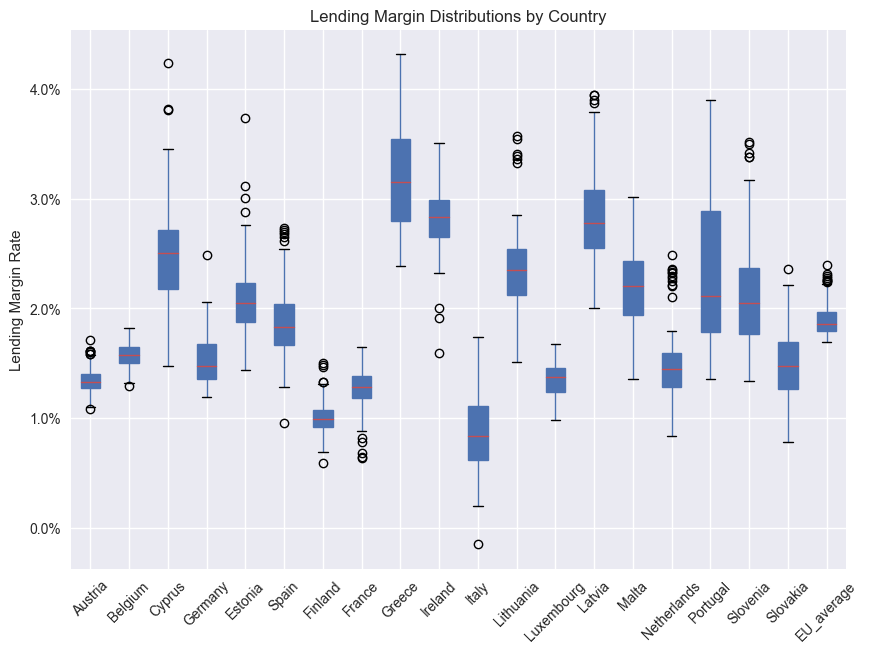

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
margins.boxplot(ax=ax, patch_artist=True)
ax.set_title('Lending Margin Distributions by Country')
ax.set_ylabel('Lending Margin Rate')
vals = ax.get_yticks()/100
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
ax.tick_params(axis='x', labelrotation=45)
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_6700\3044197746.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


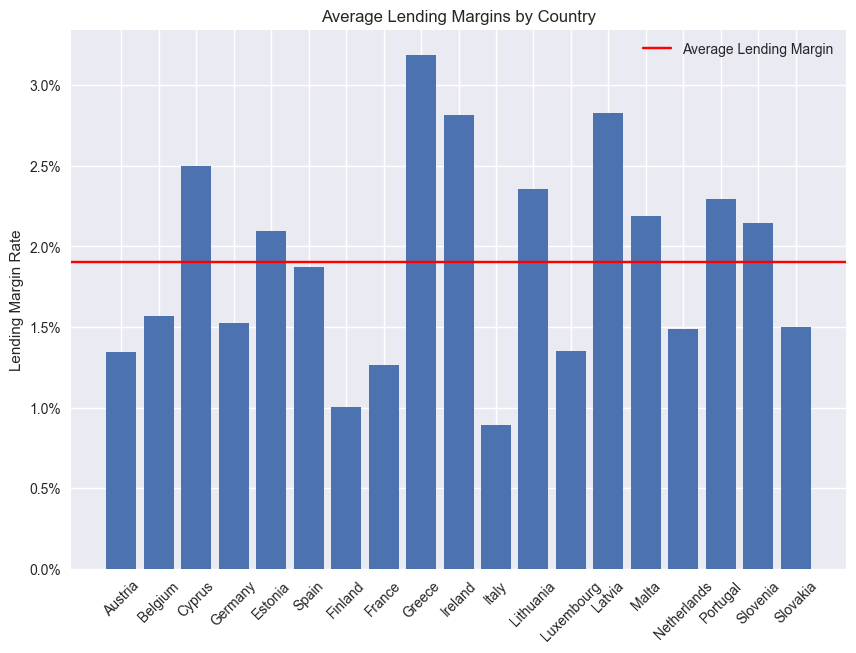

In [75]:
mean_margins = margins.drop('EU_average', axis=1).mean()

fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.bar(mean_margins.index, mean_margins)
ax.set_title('Average Lending Margins by Country')
ax.set_ylabel('Lending Margin Rate')
ax.tick_params(axis='x', labelrotation=45)
ax.axhline(y=margins['EU_average'].mean(), color='red', linestyle='-', label='Average Lending Margin')
vals = ax.get_yticks()/100
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.legend()
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_6700\3374691262.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


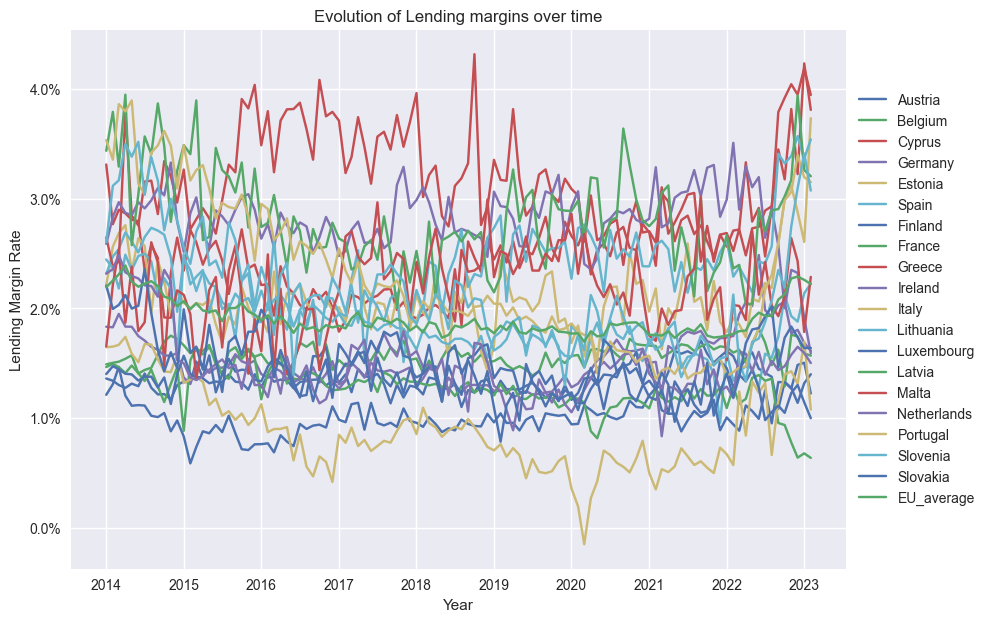

In [76]:
# Random

fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(margins.loc[:, margins.columns], 
        label=['Austria', 'Belgium', 'Cyprus', 'Germany', 'Estonia', 'Spain', 'Finland', 'France', 'Greece', 'Ireland', 'Italy', 'Lithuania',
       'Luxembourg', 'Latvia', 'Malta', 'Netherlands', 'Portugal', 'Slovenia', 'Slovakia', 'EU_average'])
ax.set_ylabel('Lending Margin Rate')
ax.set_xlabel('Year')
ax.set_title('Evolution of Lending margins over time')
vals = ax.get_yticks()/100
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_6700\1082095611.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


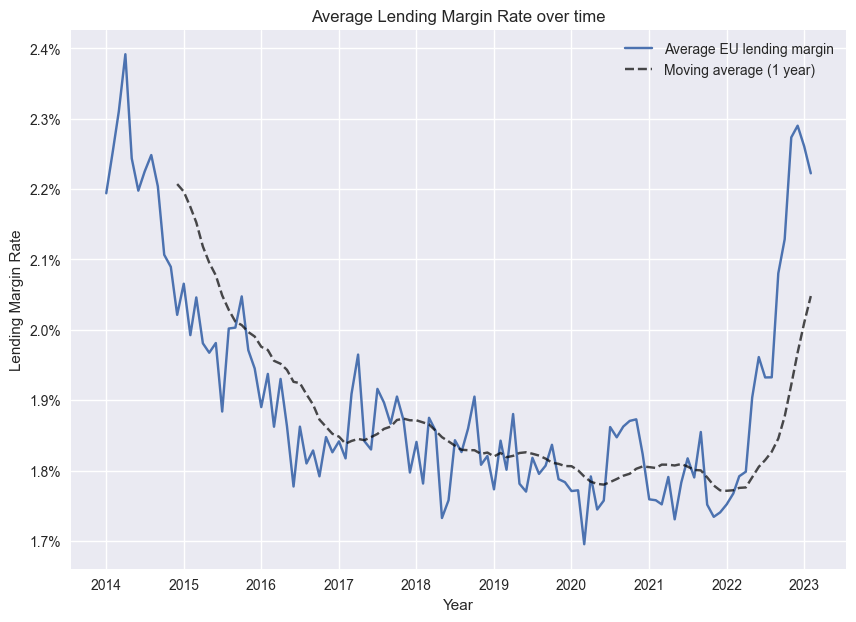

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(margins['EU_average'], label = 'Average EU lending margin')
ax.plot(margins.rolling(window=12).mean()['EU_average'], color ="black", linestyle='dashed', alpha= 0.7, label = 'Moving average (1 year)')
ax.set_ylabel('Lending Margin Rate')
ax.set_xlabel('Year')
ax.set_title('Average Lending Margin Rate over time')
vals = ax.get_yticks()/100
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.legend()
plt.show()

We note a similarity in trend with respect to the lending rates analyzed before: this confirms that the gathered data is correct.

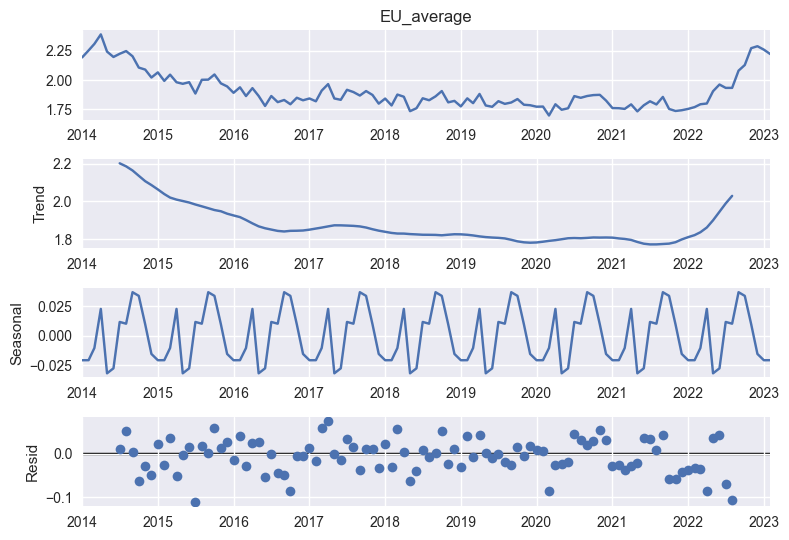

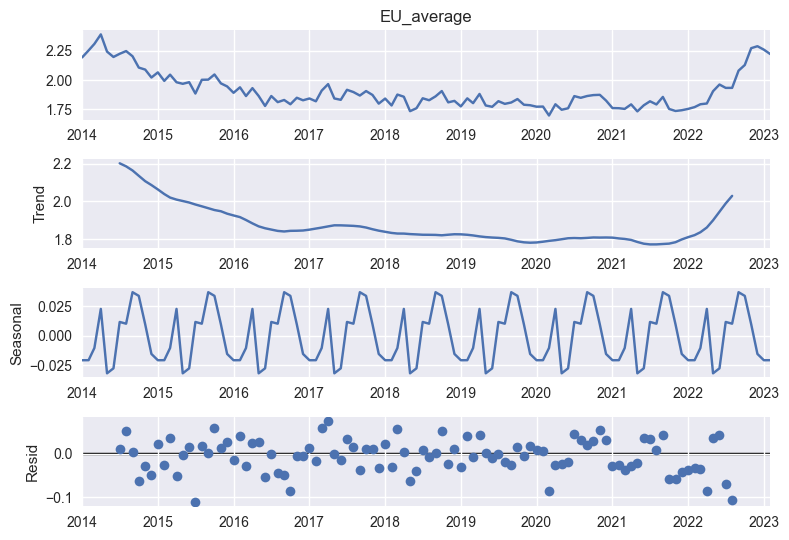

In [71]:
seasonal_decompose(margins['EU_average']).plot()

gradual decreasing trend with peak in last year, strange but present yearly seasonality